In [ ]:
# Install necessary libraries
!pip install python-chess tensorflow numpy pandas matplotlib seaborn pyyaml ipywidgets torch scikit-learn

# Ensure ipywidgets is enabled
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension enable --py --sys-prefix ipywidgets

# Remove the existing pykan directory if it exists
import shutil
import os

if os.path.exists('pykan'):
    shutil.rmtree('pykan')

# Clone the pykan repository
!git clone https://github.com/KindXiaoming/pykan

# Change directory to pykan and install it
!pip install ./pykan




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.9/738.9 kB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 105.6 MB/s eta 0:00:00
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.0
    Not uninstalling markupsafe at /shared-libs/python3.9/py-core/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/usr/local/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
   

# Experiment 2: Simple NN based Abel And Its De-Randomization Integrated with KAN

## Step 1: Overall Design Description
### Objective:
To integrate the Kolmogorov-Arnold Networks (KAN) model to analyze and interpret the equivalence between probabilistic and deterministic versions of a simple neural network-based chess AI named Abel.

### Steps:

**Data Preparation:**

- Train the Simple NN-based Abel with both probabilistic and deterministic versions.
- Collect performance metrics such as material count, mobility count, piece-square score, and center control count.
**Training and Evaluation:**

- Define a custom KAN model architecture using PyTorch.
- Train the KAN model on the collected data.
- Evaluate the model's performance and track the equivalence score during training.
### Visualization:

- Visualize the dataset.
- Plot the equivalence curve to show the relationship between the deterministic and probabilistic versions.
- Extract and visualize the symbolic formula from the trained KAN model.
- Plot the model's structure and equivalence data points.
- Visualize the weights and biases of the trained KAN model.
### Implementation:

- Implement the KAN model using the provided KAN library.
- Train the KAN model with the training data and evaluate it with test data.
- Calculate the equivalence score during each epoch of training.
- Use matplotlib for plotting and visualizing the results.

## Step 2: Define the Simple Neural Network for Abel
### 2.1: Import Required Libraries and Define Helper Functions

In [ ]:
import chess
import chess.svg
from IPython.display import display, clear_output, SVG
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import time
import random
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway

import os
import torch
import torch.nn as nn
import seaborn as sns
from kan import KAN
from sklearn.preprocessing import StandardScaler

# Setting up constants
gamma = 0.95
batch_size = 32
target_update_freq = 10

# Helpers for derandomization
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

def softmax_policy(q_values, temperature):
    q_values = np.array(q_values)  # Convert list to numpy array
    exp_values = np.exp(q_values / temperature)
    probabilities = exp_values / np.sum(exp_values)
    return np.argmax(probabilities)

# Heuristic Evaluation
def heuristic_evaluation(board):
    material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    mobility_count = len(list(board.legal_moves))
    piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())
    score = material_count + mobility_count + piece_square_score + center_control_count
    return score

# Define the Game Environment
class ChessEnv:
    def __init__(self):
        self.board = chess.Board()
    
    def reset(self):
        self.board.reset()
        return self.board
    
    def step(self, state, action):
        self.board.push(action)
        reward = heuristic_evaluation(self.board)
        done = self.board.is_game_over()
        return self.board, reward, done
    
    def legal_moves(self, state):
        return list(state.legal_moves)
    
    def simulate_move(self, state, move):
        temp_board = state.copy()
        temp_board.push(move)
        return temp_board

# Define the Simple NN Model
class AbelNN:
    def __init__(self, seed):
        self.model = self.build_model(seed)

    def build_model(self, seed):
        np.random.seed(seed)
        tf.random.set_seed(seed)
        model = Sequential([
            Flatten(input_shape=(8, 8, 12)),  # Ensure this matches the shape of the input
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        return model

    def evaluate_board(self, board):
        board_state = self.board_to_input(board)
        return self.model.predict(board_state, verbose=0)[0][0]

    def board_to_input(self, board):
        input_array = np.zeros((8, 8, 12))
        piece_to_index = {
            'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
            'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
        }
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                x, y = divmod(square, 8)
                input_array[x, y, piece_to_index[piece.symbol()]] = 1
        return np.array([input_array])



2024-08-06 12:03:17.152327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 12:03:17.254365: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 12:03:17.258732: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-06 12:03:17.258747: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

## Step 3: Training Functions
### 3.1: Training the Original Simple NN

In [ ]:
def train_simple_nn(env, num_episodes=10, seed=42, temperature=1.0):
    nn = AbelNN(seed)
    set_random_seed(seed)
    
    for e in range(num_episodes):
        state = env.reset()
        done = False
        
        while not done:
            q_values = [nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
            action_index = softmax_policy(q_values, temperature)
            action = env.legal_moves(state)[action_index]
            next_state, reward, done = env.step(state, action)
            target = reward + heuristic_evaluation(next_state)
            state_input = nn.board_to_input(state)
            nn.model.fit(state_input, np.array([target]), epochs=1, verbose=0)
            state = next_state

    return nn

# Training the original Simple NN
print("Training the original Simple NN...")
env = ChessEnv()
abel_nn_probabilistic = train_simple_nn(env, num_episodes=5, seed=42, temperature=1.0)


Training the original Simple NN...
2024-08-06 12:03:19.998537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-08-06 12:03:19.998571: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-08-06 12:03:19.998588: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-f6f51e1a-d40a-494a-8398-36807e7a81cb): /proc/driver/nvidia/version does not exist
2024-08-06 12:03:19.998807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 3.2: Training the Derandomized Simple NN

In [ ]:
def update_nn(abel_nn, target_network, batch):
    states, actions, rewards, next_states, dones = zip(*batch)
    target_q_values = [target_network.evaluate_board(state) for state in next_states]
    targets = rewards + (1 - np.array(dones)) * np.array(target_q_values)
    states = np.array([abel_nn.board_to_input(state).reshape(-1, 8, 8, 12) for state in states])
    targets = np.array(targets).reshape(-1, 1)
    print(f"Updating NN: states shape: {states.shape}, targets shape: {targets.shape}")
    abel_nn.model.train_on_batch(np.vstack(states), targets)

def train_abel_nn_derandomized(env, num_episodes, seed, temperature):
    set_random_seed(seed)
    abel_nn = AbelNN(seed)
    target_network = AbelNN(seed)
    replay_buffer = []
    batch_size = 32
    target_update_freq = 10

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            q_values = [abel_nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
            action_index = softmax_policy(q_values, temperature)
            action = env.legal_moves(state)[action_index]
            next_state, reward, done = env.step(state, action)
            replay_buffer.append((state, action, reward, next_state, done))
            state = next_state
            
            if len(replay_buffer) > batch_size:
                batch = random.sample(replay_buffer, batch_size)
                update_nn(abel_nn, target_network, batch)
        
        if episode % target_update_freq == 0:
            target_network.model.set_weights(abel_nn.model.get_weights())
    
    return abel_nn

# Training the derandomized Simple NN
print("Training the derandomized Simple NN...")
env = ChessEnv()
abel_nn_derandomized = train_abel_nn_derandomized(env, num_episodes=5, seed=42, temperature=1.0)


Training the derandomized Simple NN...
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32, 1)
Updating NN: states shape: (32, 1, 8, 8, 12), targets shape: (32

## Step 4: Simulate Games using Simple NN
### 4.1: Play Game with Probabilistic NN

In [ ]:
def play_game_nn_probabilistic(abel_nn, env, max_moves=55, max_runtime=600, temperature=1.0):
    steps, times, material_counts, mobility_counts, piece_square_scores, center_control_counts, move_list, evaluation_scores, branching_factors, depths_of_search, move_diversities, exploration_vs_exploitations = [], [], [], [], [], [], [], [], [], [], [], []
    step_number = 1
    state = env.reset()
    start_time = time.time()

    while not env.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        q_values = [abel_nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
        action_index = softmax_policy(q_values, temperature)
        action = env.legal_moves(state)[action_index]
        next_state, reward, done = env.step(state, action)
        move_end_time = time.time()

        move_list.append(action.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)
        material_counts.append(reward)

        mobility_count = len(list(env.board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in env.board.piece_map().values())
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in env.board.piece_map().items())
        evaluation_score = abel_nn.evaluate_board(env.board)
        branching_factor = len(list(env.board.legal_moves))
        depth_of_search = 3
        move_diversity = np.var([reward, mobility_count, piece_square_score, center_control_count])
        exploration_vs_exploitation = 0

        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        state = next_state
        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=env.board, size=350)))
        time.sleep(1)
        print(f"Move: {action}, Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {reward}")

    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)
    print(f"Result: {env.board.result()}")
    return df


### 4.3: Function to Play the Game with Derandomized NN

In [ ]:
def play_game_nn_derandomized(abel_nn, env, max_moves=55, max_runtime=600, temperature=0.5):
    steps, times, material_counts, mobility_counts, piece_square_scores, center_control_counts, move_list, evaluation_scores, branching_factors, depths_of_search, move_diversities, exploration_vs_exploitations = [], [], [], [], [], [], [], [], [], [], [], []
    step_number = 1
    state = env.reset()
    start_time = time.time()

    while not env.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        q_values = [abel_nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
        action_index = softmax_policy(q_values, temperature)
        action = env.legal_moves(state)[action_index]
        next_state, reward, done = env.step(state, action)
        move_end_time = time.time()

        move_list.append(action.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)
        material_counts.append(reward)

        mobility_count = len(list(env.board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in env.board.piece_map().values())
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in env.board.piece_map().items())
        evaluation_score = abel_nn.evaluate_board(env.board)
        branching_factor = len(list(env.board.legal_moves))
        depth_of_search = 3
        move_diversity = np.var([reward, mobility_count, piece_square_score, center_control_count])
        exploration_vs_exploitation = 0

        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        state = next_state
        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=env.board, size=350)))
        time.sleep(1)
        print(f"Move: {action}, Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {reward}")

    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)
    print(f"Result: {env.board.result()}")
    return df


## Step 5: Compare Abel Versions
###  5.1: Define KAN Model and Training Function

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from kan import KAN
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

class CustomKAN(nn.Module):
    def __init__(self, width, grid, k):
        super(CustomKAN, self).__init__()
        width_list = [[w, 0] for w in width]
        self.kan = KAN(width=width_list, grid=grid, k=k)
        self.dropout = nn.Dropout(p=0.5)  # Increased dropout rate
        self.fc1 = nn.Linear(width[-1], 64)  # Reduced layer size
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.kan(x)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x.squeeze()

def normalize_data(data):
    # Avoid division by zero
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    std[std == 0] = 1
    return (data - mean) / std

def train_kan_model(train_input, train_label, val_input, val_label, test_input, test_label, num_epochs=5000):
    input_size = train_input.shape[1]
    model = CustomKAN(width=[input_size, 10, 5], grid=3, k=3)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    train_losses = []
    val_accuracies = []
    test_accuracies = []
    equivalence_scores = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_input)
        loss = loss_fn(outputs, train_label.float())
        loss.backward()
        optimizer.step()
        scheduler.step()

        predicted = (outputs >= 0.5).float()
        correct = (predicted == train_label).sum().item()
        train_acc = correct / len(train_label)

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_input)
            val_predicted = (val_outputs >= 0.5).float()
            val_correct = (val_predicted == val_label).sum().item()
            val_acc = val_correct / len(val_label)

            test_outputs = model(test_input)
            test_predicted = (test_outputs >= 0.5).float()
            test_correct = (test_predicted == test_label).sum().item()
            test_acc = test_correct / len(test_label)

        train_losses.append(loss.item())
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)

        min_length = min(len(train_input), len(test_input))
        f_kan_a = model(train_input[:min_length]).detach().numpy()
        f_kan_b = model(test_input[:min_length]).detach().numpy()
        numerator = np.linalg.norm(f_kan_a - f_kan_b)
        denominator = np.linalg.norm(f_kan_a) + np.linalg.norm(f_kan_b)
        equivalence_score = 1 - (numerator / denominator)
        equivalence_scores.append(equivalence_score)

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}, Equivalence Score: {equivalence_score:.4f}')

    return model, equivalence_scores

### 5.2: Define compare_abel_versions Function

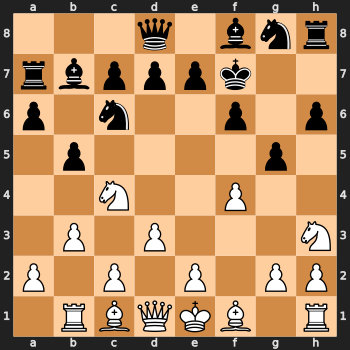

Move: g7f8, Step: 35, Time: 0.9777460098266602, Material: 32
Result: 1/2-1/2
checkpoint directory created: ./model
saving model version 0.0
Epoch [100/5000], Loss: 0.0153, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7875
Epoch [200/5000], Loss: 0.0038, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.8064
Epoch [300/5000], Loss: 0.0030, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.8190
Epoch [400/5000], Loss: 0.0014, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.8283
Epoch [500/5000], Loss: 0.0010, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.8371
Epoch [600/5000], Loss: 0.0006, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.8450
Epoch [700/5000], Loss: 0.0003, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.000

In [ ]:
def ensure_dataframe(data):
    if isinstance(data, pd.DataFrame):
        return data
    return pd.DataFrame(data)

def compare_abel_versions(probabilistic_nn, derandomized_nn, env, games=3, max_moves=55, max_runtime=300):
    probabilistic_results = []
    derandomized_results = []

    for _ in range(games):
        env.reset()
        probabilistic_data = play_game_nn_probabilistic(probabilistic_nn, env, max_moves, max_runtime)
        probabilistic_results.append(probabilistic_data)

        env.reset()
        derandomized_data = play_game_nn_derandomized(derandomized_nn, env, max_moves, max_runtime)
        derandomized_results.append(derandomized_data)

    probabilistic_results = [ensure_dataframe(df) for df in probabilistic_results]
    derandomized_results = [ensure_dataframe(df) for df in derandomized_results]

    # Define numeric_columns
    numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                       'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                       'Exploration vs Exploitation']

    combined_probabilistic_data = pd.concat(probabilistic_results, ignore_index=True)
    combined_derandomized_data = pd.concat(derandomized_results, ignore_index=True)

    combined_probabilistic_normalized = normalize_data(combined_probabilistic_data[numeric_columns].values)
    combined_derandomized_normalized = normalize_data(combined_derandomized_data[numeric_columns].values)

    # Ensure input dimensions match expected KAN model input
    input_dim = combined_probabilistic_normalized.shape[1]
    train_input, val_input, train_label, val_label = train_test_split(
        combined_probabilistic_normalized, np.ones(len(combined_probabilistic_normalized)), test_size=0.2, random_state=42)
    test_input = combined_derandomized_normalized
    test_label = np.zeros(len(test_input))

    train_input = torch.from_numpy(train_input).float()
    val_input = torch.from_numpy(val_input).float()
    test_input = torch.from_numpy(test_input).float()
    train_label = torch.from_numpy(train_label).long()
    val_label = torch.from_numpy(val_label).long()
    test_label = torch.from_numpy(test_label).long()

    kan_model, equivalence_scores = train_kan_model(train_input, train_label, val_input, val_label, test_input, test_label)

    return probabilistic_results, derandomized_results, kan_model, equivalence_scores

# Compare the two versions over multiple games
probabilistic_results, derandomized_results, kan_model, equivalence_scores = compare_abel_versions(abel_nn_probabilistic, abel_nn_derandomized, env, games=5)

### Step 6: Aggregate Data and Calculate Metrics

In [ ]:
# Aggregate metrics function
def aggregate_metrics(results):
    numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                       'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                       'Exploration vs Exploitation']
    aggregated_data = pd.concat(results, ignore_index=True)
    mean_metrics = aggregated_data[numeric_columns].mean()
    std_metrics = aggregated_data[numeric_columns].std()
    return mean_metrics, std_metrics, aggregated_data

# Convert results to DataFrames
probabilistic_results = [ensure_dataframe(df) for df in probabilistic_results]
derandomized_results = [ensure_dataframe(df) for df in derandomized_results]

# Aggregate the results
probabilistic_mean, probabilistic_std, probabilistic_data = aggregate_metrics(probabilistic_results)
derandomized_mean, derandomized_std, derandomized_data = aggregate_metrics(derandomized_results)

# Display the aggregated metrics
print("Probabilistic NN Mean Metrics:\n", probabilistic_mean)
print("Probabilistic NN Std Metrics:\n", probabilistic_std)
print("\nDerandomized NN Mean Metrics:\n", derandomized_mean)
print("Derandomized NN Std Metrics:\n", derandomized_std)

# Display move sequences and non-numeric data
print("\nProbabilistic Moves:\n", probabilistic_data['Move'])
print("\nDerandomized Moves:\n", derandomized_data['Move'])


Probabilistic NN Mean Metrics:
 Material Count                  29.354839
Mobility Count                  28.580645
Piece-Square Score               0.000000
Center Control Count             0.774194
Evaluation Score                58.738937
Branching Factor                28.580645
Depth of Search                  3.000000
Move Diversity                 206.612903
Exploration vs Exploitation      0.000000
dtype: float64
Probabilistic NN Std Metrics:
 Material Count                  3.198502
Mobility Count                  2.980175
Piece-Square Score              0.000000
Center Control Count            0.419468
Evaluation Score                3.748347
Branching Factor                2.980175
Depth of Search                 0.000000
Move Diversity                 39.573971
Exploration vs Exploitation     0.000000
dtype: float64

Derandomized NN Mean Metrics:
 Material Count                  26.205882
Mobility Count                  26.205882
Piece-Square Score               0.000000
Ce

## Step 7: Plot Comparison Metrics and Equivalence Curve

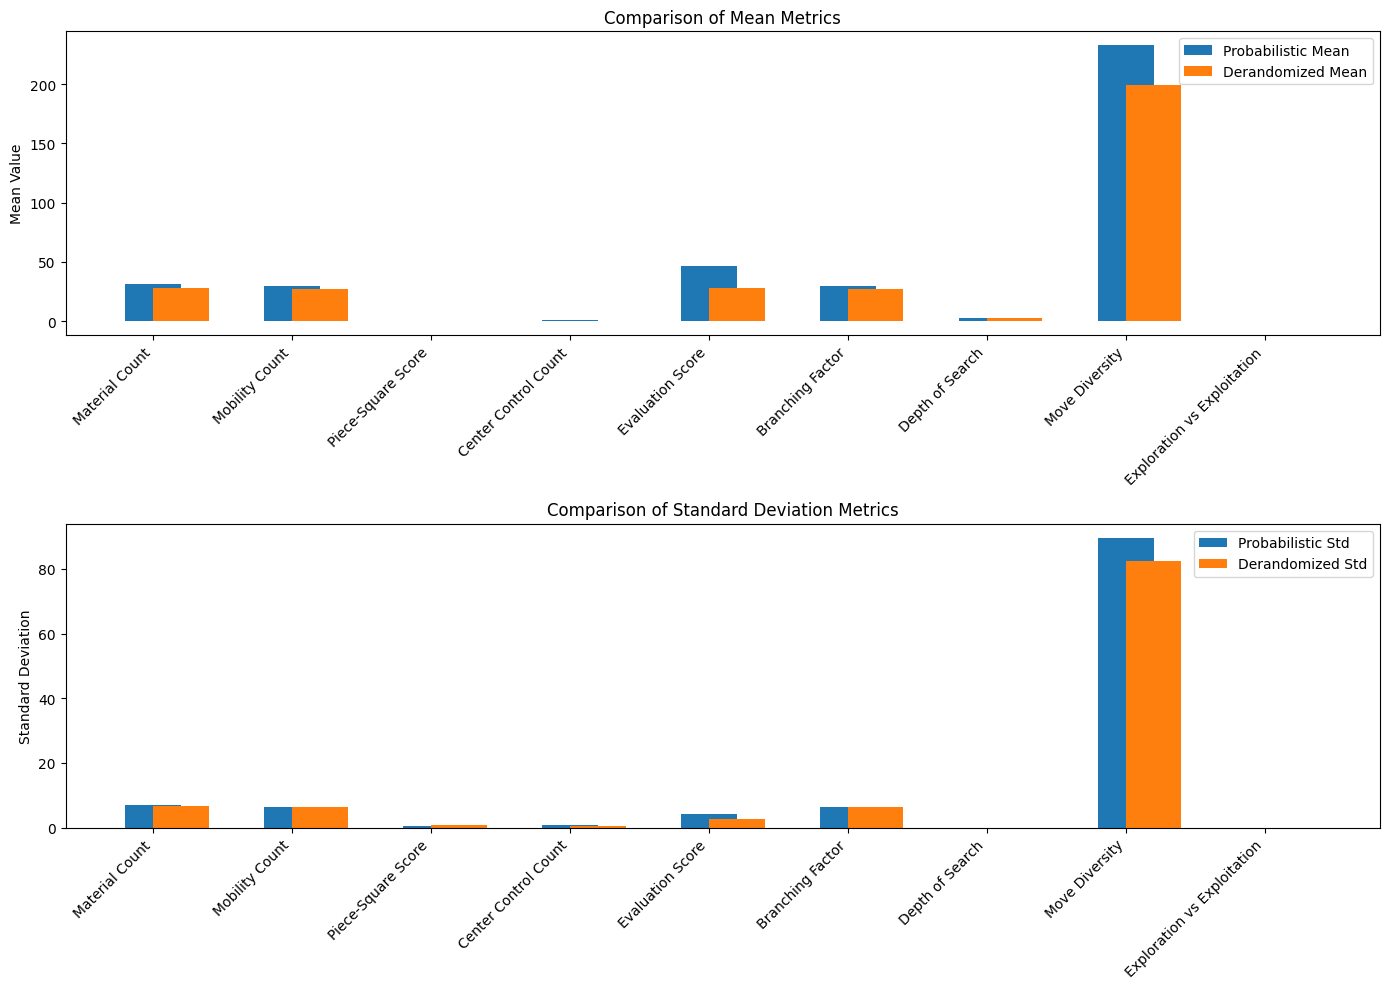

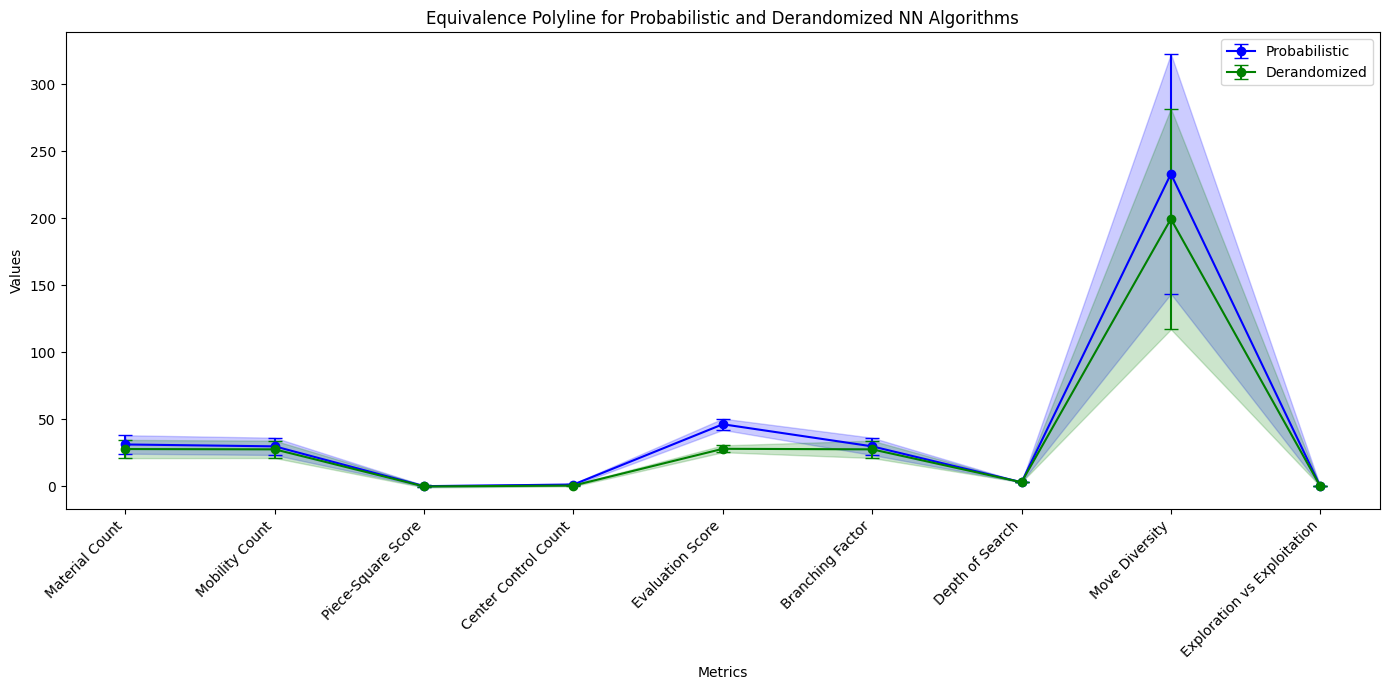

In [ ]:
# Plot comparison metrics
def plot_comparison_metrics(probabilistic_mean, probabilistic_std, derandomized_mean, derandomized_std):
    metrics = probabilistic_mean.index
    x = range(len(metrics))

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plot means
    axs[0].bar(x, probabilistic_mean, width=0.4, label='Probabilistic Mean', align='center')
    axs[0].bar(x, derandomized_mean, width=0.4, label='Derandomized Mean', align='edge')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(metrics, rotation=45, ha='right')
    axs[0].set_ylabel('Mean Value')
    axs[0].set_title('Comparison of Mean Metrics')
    axs[0].legend()

    # Plot standard deviations
    axs[1].bar(x, probabilistic_std, width=0.4, label='Probabilistic Std', align='center')
    axs[1].bar(x, derandomized_std, width=0.4, label='Derandomized Std', align='edge')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(metrics, rotation=45, ha='right')
    axs[1].set_ylabel('Standard Deviation')
    axs[1].set_title('Comparison of Standard Deviation Metrics')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Plot the comparison metrics
plot_comparison_metrics(probabilistic_mean, probabilistic_std, derandomized_mean, derandomized_std)

# Plot equivalence curve
def plot_equivalence_curve(probabilistic_mean, probabilistic_std, derandomized_mean, derandomized_std, equivalence_scores):
    metrics = probabilistic_mean.index
    x = np.arange(len(metrics))

    fig, ax = plt.subplots(figsize=(14, 7))

    ax.errorbar(x, probabilistic_mean, yerr=probabilistic_std, fmt='o-', label='Probabilistic', color='blue', capsize=5)
    ax.errorbar(x, derandomized_mean, yerr=derandomized_std, fmt='o-', label='Derandomized', color='green', capsize=5)
    ax.fill_between(x, probabilistic_mean - probabilistic_std, probabilistic_mean + probabilistic_std, color='blue', alpha=0.2)
    ax.fill_between(x, derandomized_mean - derandomized_std, derandomized_mean + derandomized_std, color='green', alpha=0.2)

    ax.set_title('Equivalence Polyline for Probabilistic and Derandomized NN Algorithms')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Plot the equivalence curve
plot_equivalence_curve(probabilistic_mean, probabilistic_std, derandomized_mean, derandomized_std, equivalence_scores)


## Step 8: Perform Statistical Tests

/tmp/ipykernel_665/3464751602.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value_t = ttest_ind(probabilistic_data[metric], derandomized_data[metric], equal_var=False)
/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/stats/_stats_py.py:3906: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
Material Count: t-statistic = 5.860876183759845, p-value (t-test) = 7.955514813354506e-09
Material Count: f-statistic = 34.349869641363355, p-value (F-test) = 7.955127830937017e-09

Mobility Count: t-statistic = 4.060938801227609, p-value (t-test) = 5.600488505527596e-05
Mobility Count: f-statistic = 16.491223947315905, p-value (F-test) = 5.600483329060128e-05

Piece-Square Score: t-statistic = 3.806748914129184, p-value (t-test) = 0.000158991955623

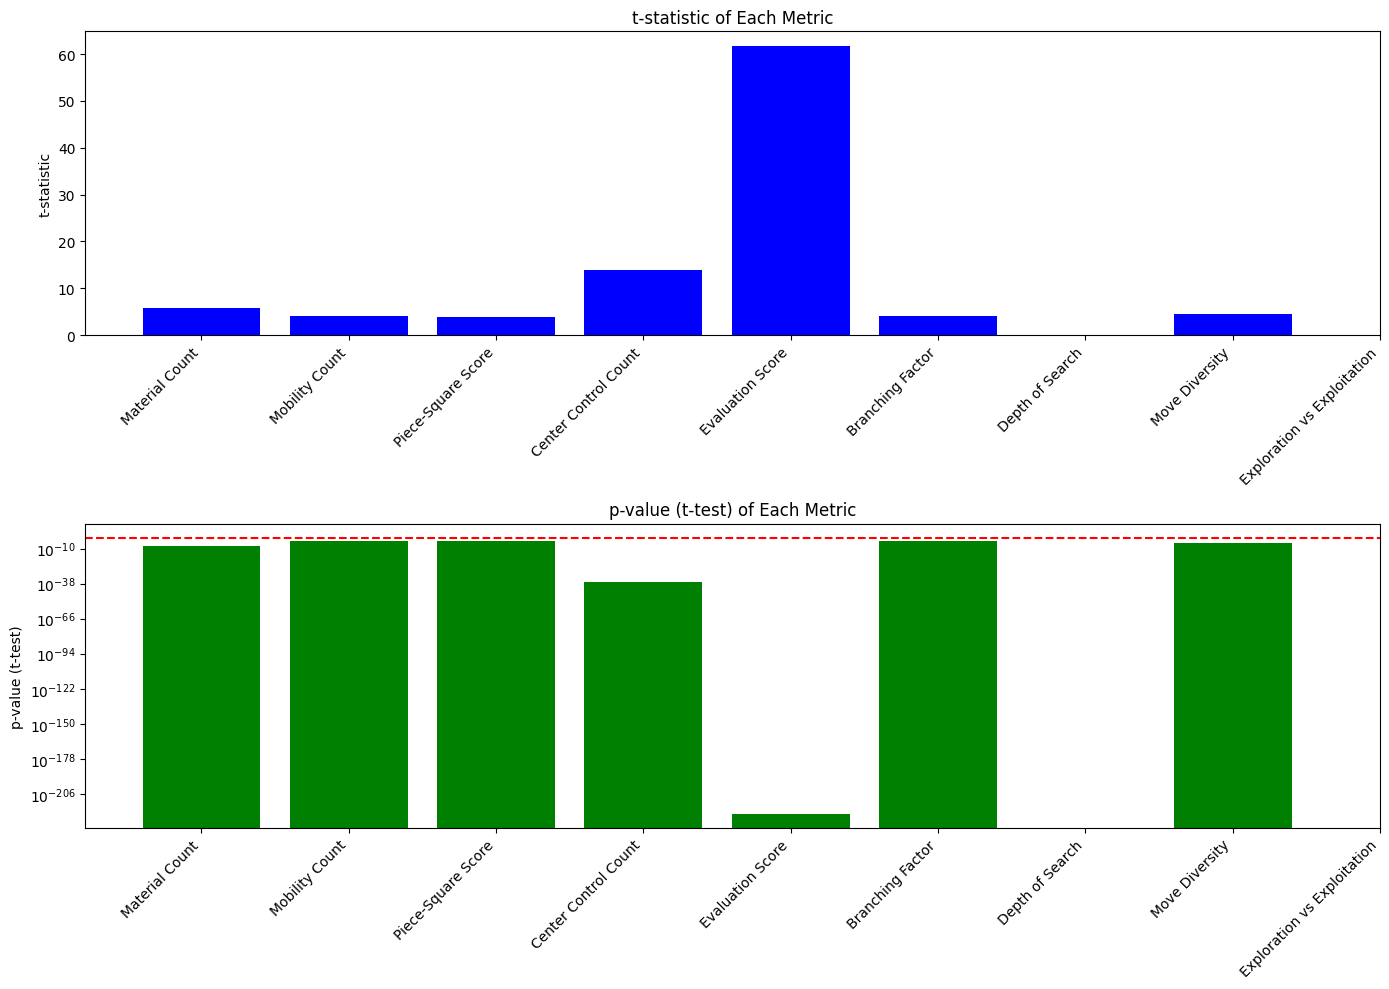

In [ ]:
from scipy.stats import ttest_ind, f_oneway

# Function to perform statistical tests
def perform_statistical_tests(probabilistic_data, derandomized_data):
    results = {}
    for metric in probabilistic_data.columns:
        if metric in ['Move', 'Step', 'Time']:
            continue
        t_stat, p_value_t = ttest_ind(probabilistic_data[metric], derandomized_data[metric], equal_var=False)
        f_stat, p_value_f = f_oneway(probabilistic_data[metric], derandomized_data[metric])
        results[metric] = {
            't_stat': t_stat,
            'p_value_t': p_value_t,
            'f_stat': f_stat,
            'p_value_f': p_value_f
        }
    return results

# Perform statistical tests
statistical_results = perform_statistical_tests(probabilistic_data, derandomized_data)

# Display the results
for metric, result in statistical_results.items():
    print(f"{metric}: t-statistic = {result['t_stat']}, p-value (t-test) = {result['p_value_t']}")
    print(f"{metric}: f-statistic = {result['f_stat']}, p-value (F-test) = {result['p_value_f']}\n")

# Plot statistical analysis results
def plot_statistical_analysis(statistical_results):
    metrics = list(statistical_results.keys())
    t_stats = [result['t_stat'] for result in statistical_results.values()]
    p_values_t = [result['p_value_t'] for result in statistical_results.values()]

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plot t-statistics
    axs[0].bar(metrics, t_stats, color='blue')
    axs[0].set_xticks(metrics)
    axs[0].set_xticklabels(metrics, rotation=45, ha='right')
    axs[0].set_ylabel('t-statistic')
    axs[0].set_title('t-statistic of Each Metric')

    # Plot p-values (t-test)
    axs[1].bar(metrics, p_values_t, color='green')
    axs[1].set_xticks(metrics)
    axs[1].set_xticklabels(metrics, rotation=45, ha='right')
    axs[1].axhline(y=0.05, color='r', linestyle='--')
    axs[1].set_ylabel('p-value (t-test)')
    axs[1].set_title('p-value (t-test) of Each Metric')
    axs[1].set_yscale('log') 

    plt.tight_layout()
    plt.show()

# Plot statistical analysis results
plot_statistical_analysis(statistical_results)

## Step 9: Additional Games and Combined Metrics

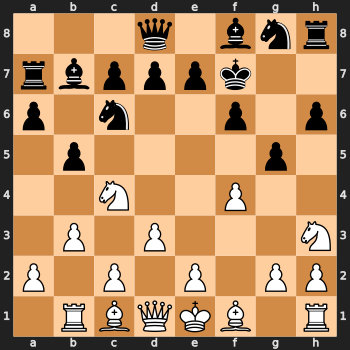

Move: g7f8, Step: 35, Time: 0.9789378643035889, Material: 32
Result: 1/2-1/2
checkpoint directory created: ./model
saving model version 0.0
Epoch [100/5000], Loss: 0.0130, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7931
Epoch [200/5000], Loss: 0.0053, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.8056
Epoch [300/5000], Loss: 0.0018, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.8165
Epoch [400/5000], Loss: 0.0008, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.8274
Epoch [500/5000], Loss: 0.0014, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.8376
Epoch [600/5000], Loss: 0.0009, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.8465
Epoch [700/5000], Loss: 0.0003, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.000

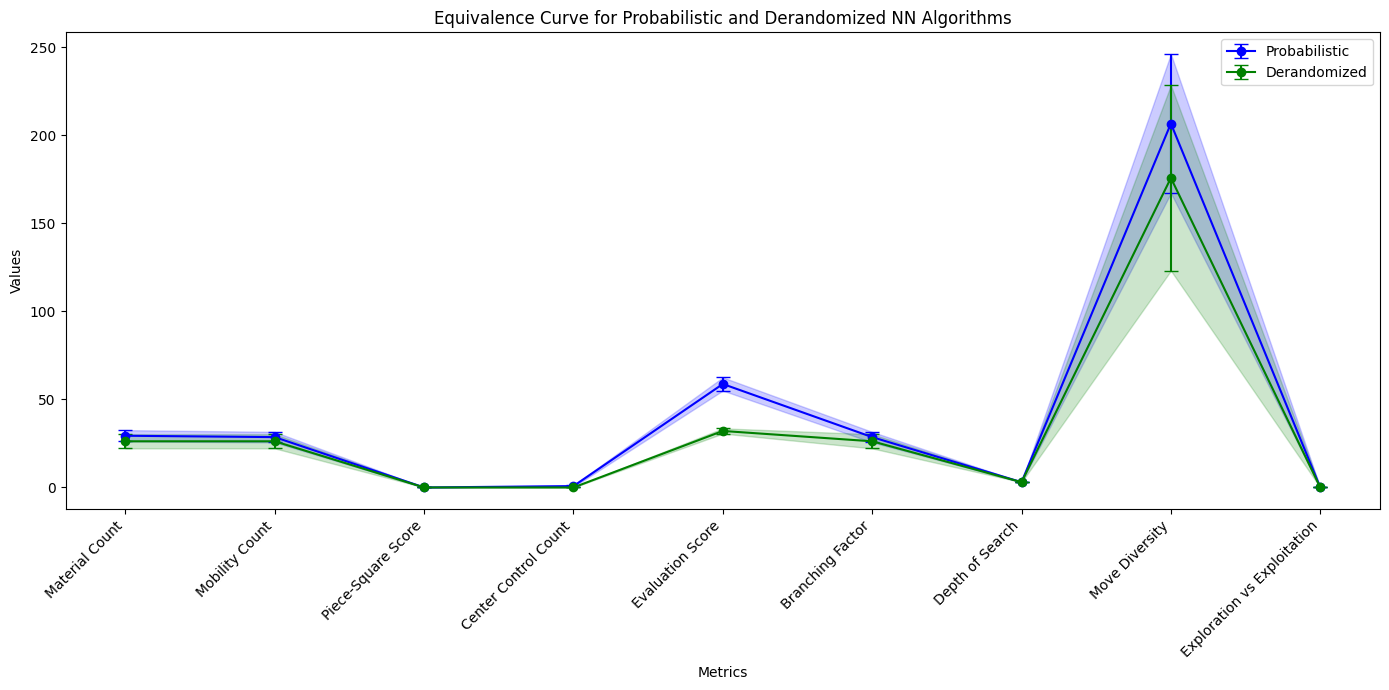

In [ ]:
# Run additional games to gather more data
additional_games = 15
probabilistic_results_additional, derandomized_results_additional, _, _ = compare_abel_versions(abel_nn_probabilistic, abel_nn_derandomized, env, games=additional_games)

# Convert additional results to DataFrames
probabilistic_results_additional = [ensure_dataframe(df) for df in probabilistic_results_additional]
derandomized_results_additional = [ensure_dataframe(df) for df in derandomized_results_additional]

# Aggregate the additional data
probabilistic_mean_additional, probabilistic_std_additional, probabilistic_data_additional = aggregate_metrics(probabilistic_results_additional)
derandomized_mean_additional, derandomized_std_additional, derandomized_data_additional = aggregate_metrics(derandomized_results_additional)

# Combine the original and additional data
combined_probabilistic_data = pd.concat([probabilistic_data, probabilistic_data_additional], ignore_index=True)
combined_derandomized_data = pd.concat([derandomized_data, derandomized_data_additional], ignore_index=True)

# Aggregate the combined data to recalculate means and standard deviations
combined_probabilistic_mean, combined_probabilistic_std, _ = aggregate_metrics([combined_probabilistic_data])
combined_derandomized_mean, combined_derandomized_std, _ = aggregate_metrics([combined_derandomized_data])

# Display the combined metrics
print("Combined Probabilistic Mean Metrics:\n", combined_probabilistic_mean)
print("Combined Probabilistic Std Metrics:\n", combined_probabilistic_std)
print("\nCombined Derandomized Mean Metrics:\n", combined_derandomized_mean)
print("Combined Derandomized Std Metrics:\n", combined_derandomized_std)

# Plot the equivalence curve again with combined data
plot_equivalence_curve(combined_probabilistic_mean, combined_probabilistic_std, combined_derandomized_mean, combined_derandomized_std, equivalence_scores)


## Step 10: Visualize and Extract Results from KAN Model

/tmp/ipykernel_665/3654829038.py:12: RuntimeWarning: invalid value encountered in divide
  normalized_data = (data - mean) / std
/tmp/ipykernel_665/3654829038.py:12: RuntimeWarning: invalid value encountered in divide
  normalized_data = (data - mean) / std


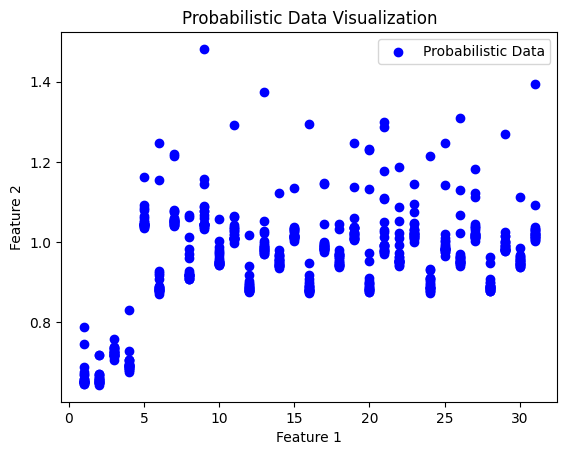

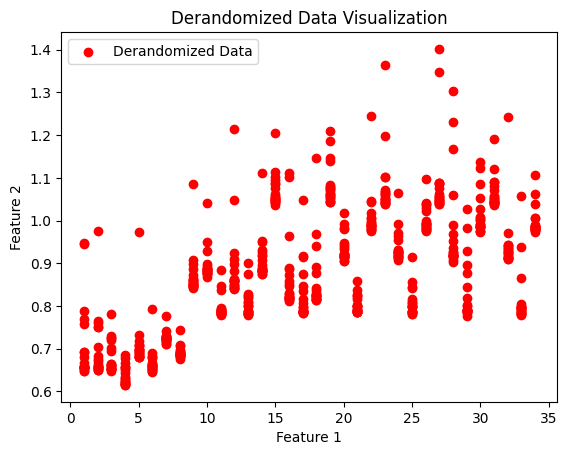

Symbolic Formula: ([0, 0, 0, 0, 0], [x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9])


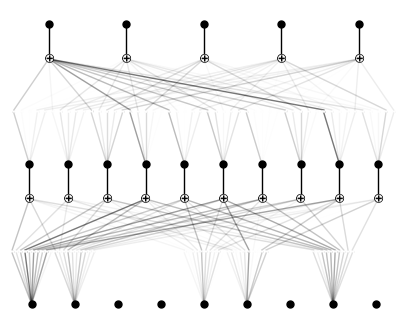

Train Predictions Shape: (496,)
Test Predictions Shape: (680,)
Train Predictions: [17.0648    16.73653   13.84592   14.129709  17.847351  13.84592
 17.847351  16.777472  13.842147  17.850166  17.74679   16.810085
 16.73653   16.810085  16.810085  13.742219  17.0648    16.810085
 13.25828   17.74679   13.842147  13.84592   17.847351  13.84592
 13.84592   17.847351  16.73653   13.25828   13.84592   14.1909895
 16.73653   16.810085  16.73653   17.847351  13.296118  13.742219
 17.847351  17.74679   13.742219  13.84592   17.74679   17.847351
 17.847351  13.84592   16.73653   13.842147  14.1909895 14.129709
 17.847351  13.84592   16.73653   17.847351  17.847351  13.84592
 16.73653   14.129709  16.73653   14.129709  16.6917    13.84592
 13.84592   13.842147  14.129709  12.635504  13.296118  12.635504
 13.842147  13.84592   13.842147  13.84592   16.73653   13.842147
 13.84592   17.850166  16.73653   16.73653   16.73653   13.84592
 13.25828   13.84592   17.847351  13.25828   13.842147  16.73653

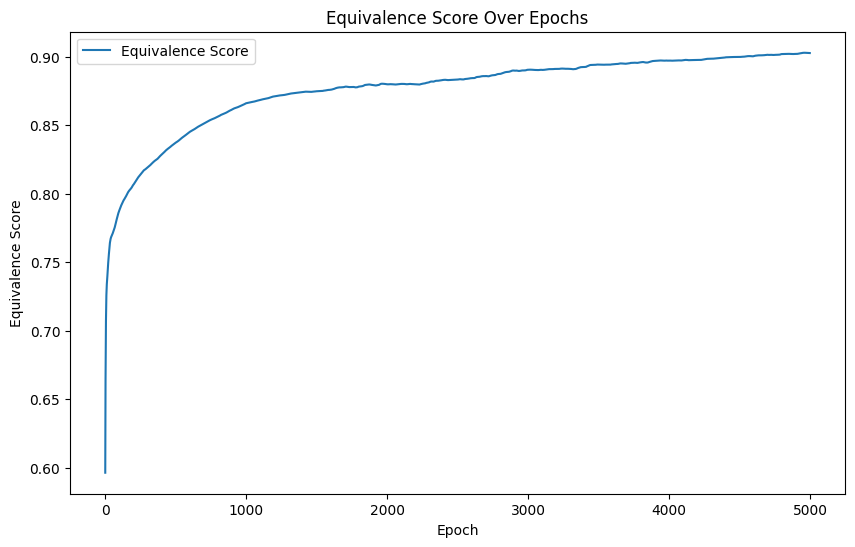

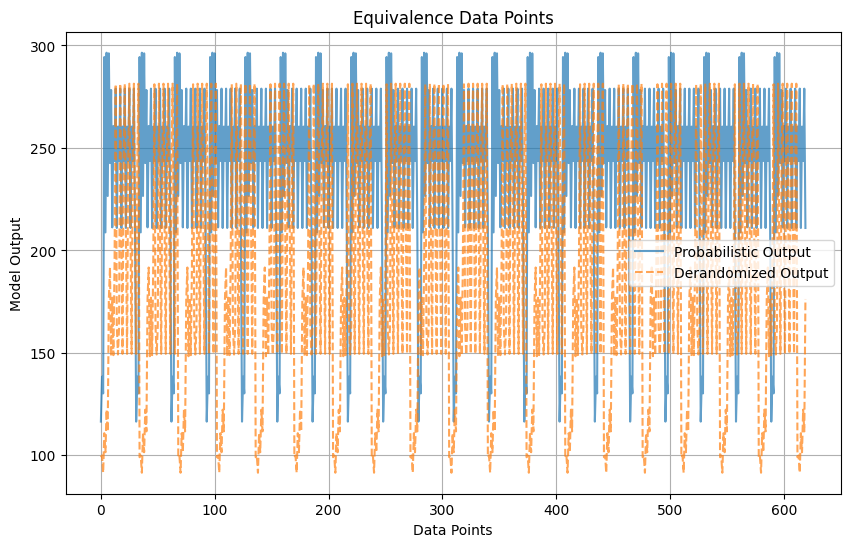

Available keys in the model's state dictionary: ['node_bias_0', 'node_scale_0', 'subnode_bias_0', 'subnode_scale_0', 'node_bias_1', 'node_scale_1', 'subnode_bias_1', 'subnode_scale_1', 'act_fun.0.grid', 'act_fun.0.coef', 'act_fun.0.scale_base', 'act_fun.0.scale_sp', 'act_fun.0.mask', 'act_fun.1.grid', 'act_fun.1.coef', 'act_fun.1.scale_base', 'act_fun.1.scale_sp', 'act_fun.1.mask', 'symbolic_fun.0.mask', 'symbolic_fun.0.affine', 'symbolic_fun.1.mask', 'symbolic_fun.1.affine']


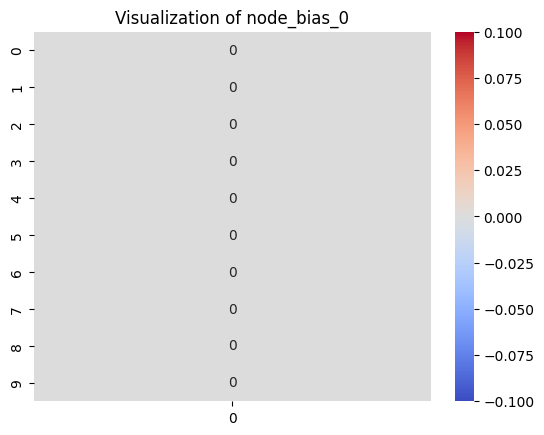

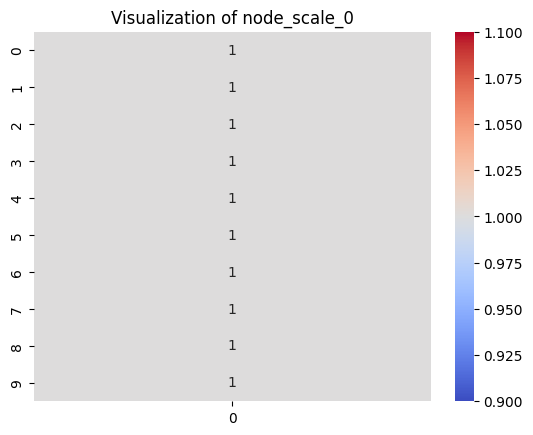

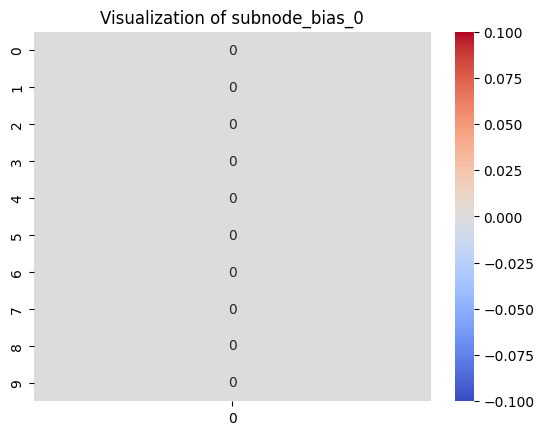

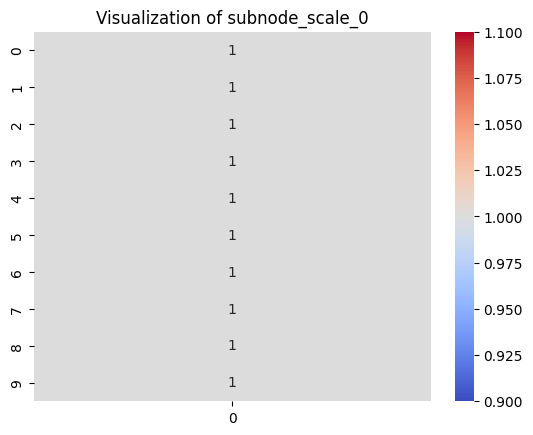

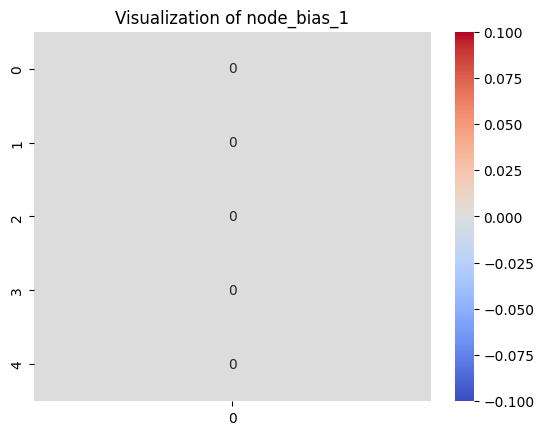

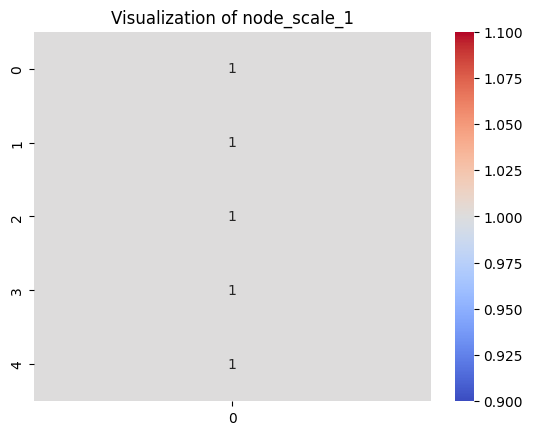

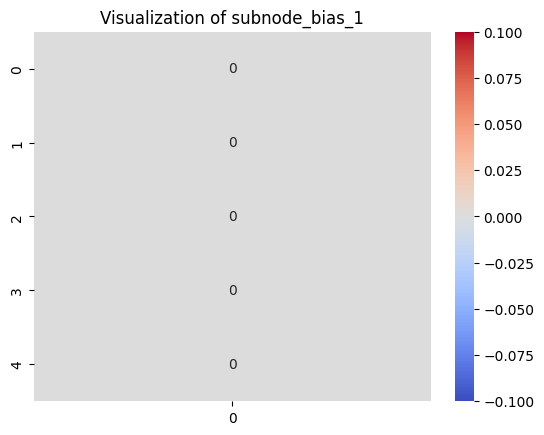

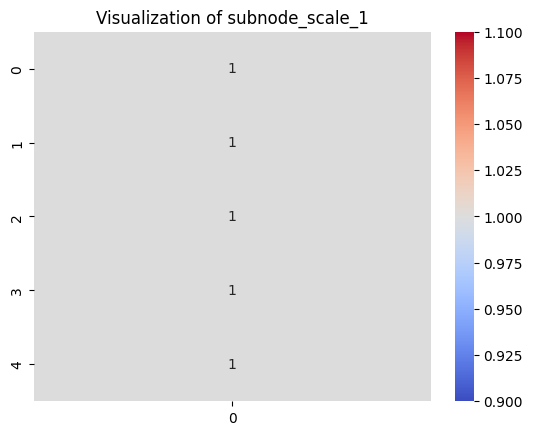

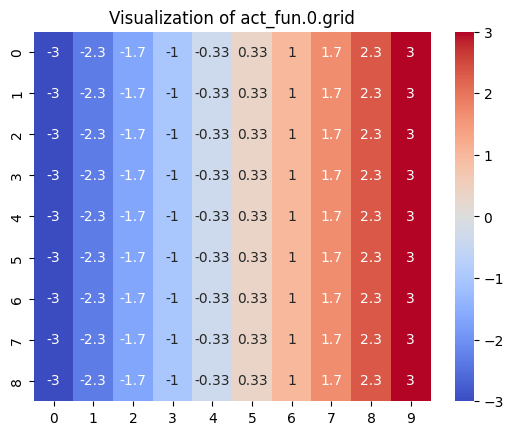

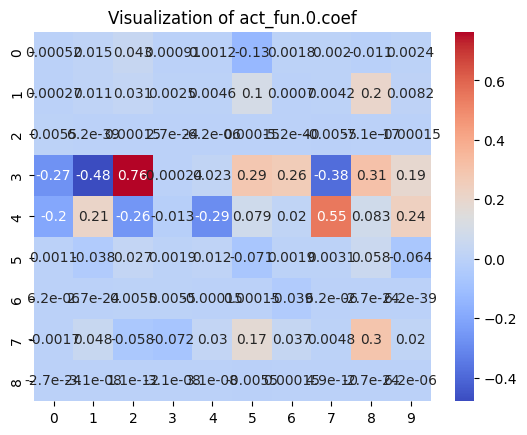

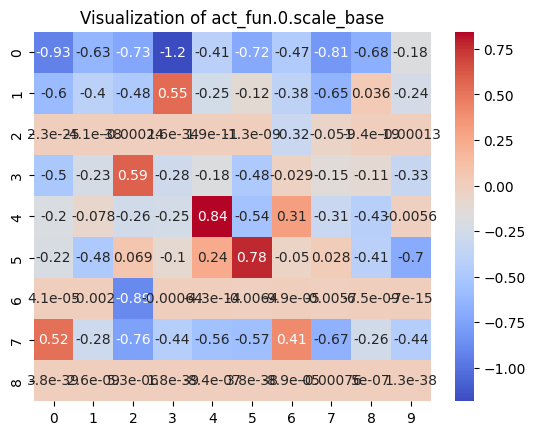

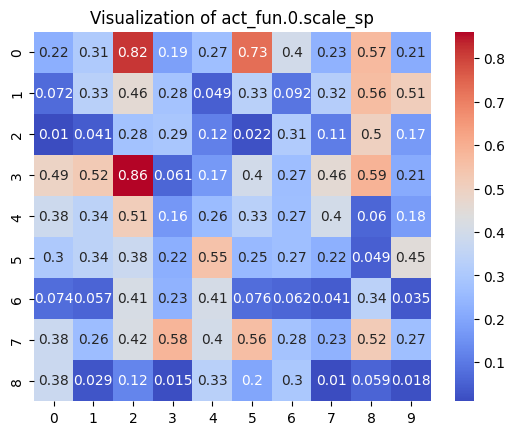

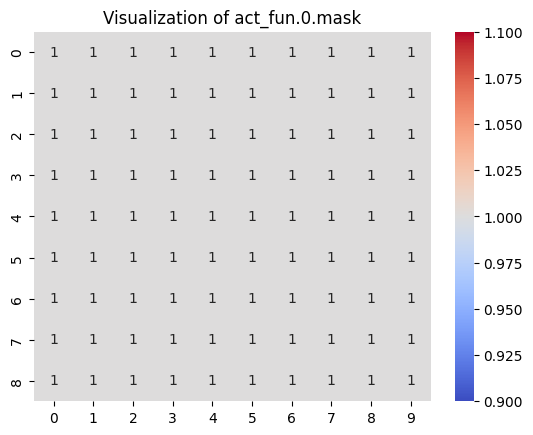

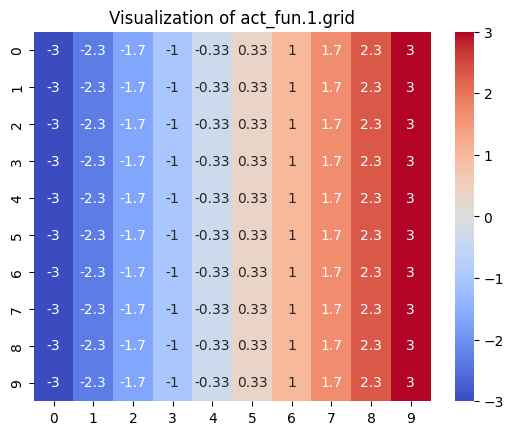

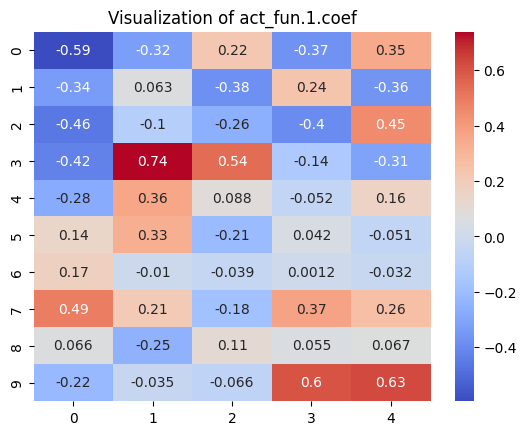

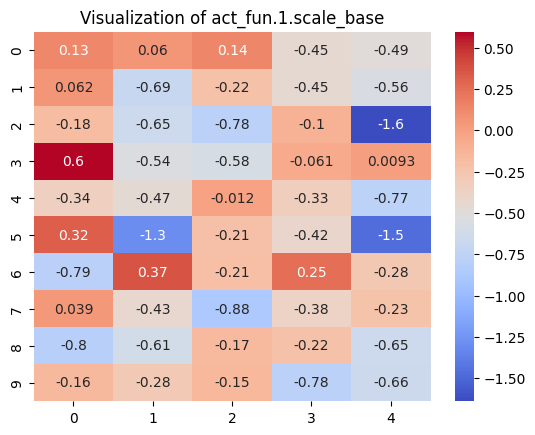

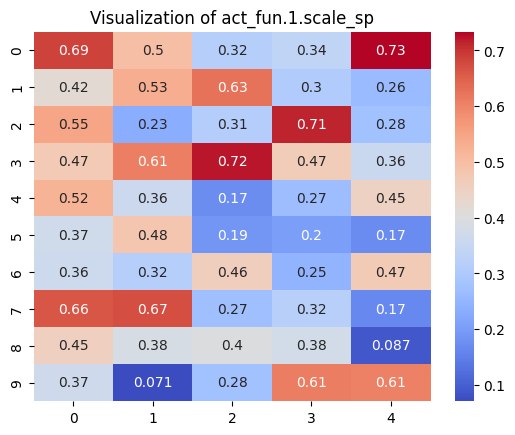

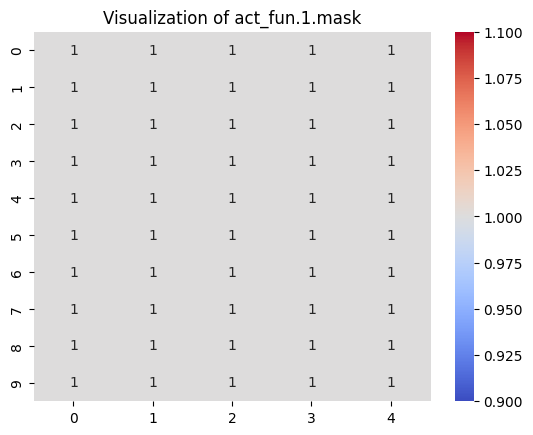

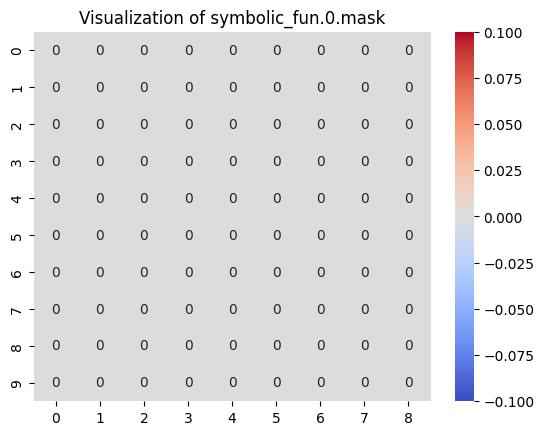

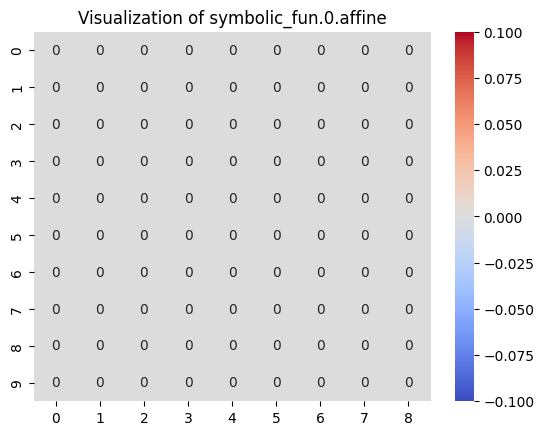

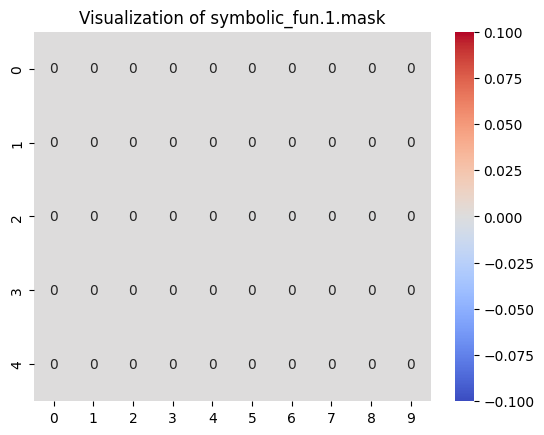

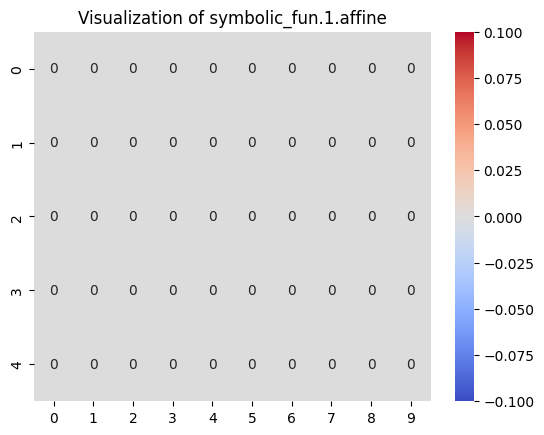

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split

# Normalize the data and handle NaNs
def normalize_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normalized_data = (data - mean) / std
    normalized_data = np.nan_to_num(normalized_data)  # Replace NaNs with 0
    return normalized_data

# Define numeric_columns
numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                   'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                   'Exploration vs Exploitation']

# Ensure train_input and test_input are defined
train_input = torch.from_numpy(normalize_data(combined_probabilistic_data[numeric_columns].values.astype(np.float32)))
test_input = torch.from_numpy(normalize_data(combined_derandomized_data[numeric_columns].values.astype(np.float32)))
train_label = torch.from_numpy(np.ones(len(train_input))).float()
test_label = torch.from_numpy(np.zeros(len(test_input))).float()

# Split the data into training, validation, and test sets
train_input, val_input, train_label, val_label = train_test_split(train_input.numpy(), train_label.numpy(), test_size=0.2, random_state=42)

# Convert back to torch tensors
train_input = torch.from_numpy(train_input)
val_input = torch.from_numpy(val_input)
train_label = torch.from_numpy(train_label)
val_label = torch.from_numpy(val_label)

# Visualize the probabilistic dataset
plt.scatter(combined_probabilistic_data.iloc[:, 0], combined_probabilistic_data.iloc[:, 1], c='blue', label='Probabilistic Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Probabilistic Data Visualization')
plt.legend()
plt.show()

# Visualize the derandomized dataset
plt.scatter(combined_derandomized_data.iloc[:, 0], combined_derandomized_data.iloc[:, 1], c='red', label='Derandomized Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Derandomized Data Visualization')
plt.legend()
plt.show()

# Ensure the required image is in place for plotting
img_src_path = '/work/pykan/kan/assets/img/sum_symbol.png'
img_dest_path = '/root/venv/lib/python3.9/site-packages/kan/assets/img/sum_symbol.png'
if not os.path.exists(img_dest_path):
    os.makedirs(os.path.dirname(img_dest_path), exist_ok=True)
    os.system(f'cp {img_src_path} {img_dest_path}')

# Extract symbolic formula
symbolic_formula = kan_model.kan.symbolic_formula()
print(f'Symbolic Formula: {symbolic_formula}')

# Plot model structure
try:
    kan_model.kan.plot()
    plt.show()
except FileNotFoundError as e:
    print(f"Error plotting model: {e}")
except ValueError as e:
    print(f"Value error while plotting model: {e}")

# Prepare data for plotting
train_predictions = kan_model(train_input.float()).detach().numpy()
test_predictions = kan_model(test_input.float()).detach().numpy()

# Print the shapes and values of predictions to debug
print("Train Predictions Shape:", train_predictions.shape)
print("Test Predictions Shape:", test_predictions.shape)
print("Train Predictions:", train_predictions)
print("Test Predictions:", test_predictions)

# Plot equivalence score
plt.figure(figsize=(10, 6))
plt.plot(range(len(equivalence_scores)), equivalence_scores, label='Equivalence Score')
plt.xlabel('Epoch')
plt.ylabel('Equivalence Score')
plt.title('Equivalence Score Over Epochs')
plt.legend()
plt.savefig('equivalence_curve.png')
plt.show()

# Ensure that probabilistic_data and derandomized_data are converted to numpy arrays
probabilistic_data_array = combined_probabilistic_data[numeric_columns].values.astype(np.float32)
derandomized_data_array = combined_derandomized_data[numeric_columns].values.astype(np.float32)

# Generate a larger set of data points for both probabilistic and derandomized outputs
probabilistic_data_points = kan_model(torch.from_numpy(probabilistic_data_array).float()).detach().numpy()
derandomized_data_points = kan_model(torch.from_numpy(derandomized_data_array).float()).detach().numpy()

# Flatten the outputs to match the number of data points
probabilistic_data_points = probabilistic_data_points.flatten()
derandomized_data_points = derandomized_data_points.flatten()

# Ensure the length of both data sets are the same for plotting
min_length = min(len(probabilistic_data_points), len(derandomized_data_points))
probabilistic_data_points = probabilistic_data_points[:min_length]
derandomized_data_points = derandomized_data_points[:min_length]

# Plot equivalence data points
plt.figure(figsize=(10, 6))
plt.plot(probabilistic_data_points, label='Probabilistic Output', linestyle='-', alpha=0.7)
plt.plot(derandomized_data_points, label='Derandomized Output', linestyle='--', alpha=0.7)
plt.xlabel('Data Points')
plt.ylabel('Model Output')
plt.title('Equivalence Data Points')
plt.legend()
plt.grid(True)
plt.savefig('equivalence_data_points_detailed.png')
plt.show()

# Extract the weights and biases from the trained KAN model
weights = kan_model.kan.state_dict()

# List the available keys
keys = list(weights.keys())
print("Available keys in the model's state dictionary:", keys)

def visualize_weights(key):
    data = weights[key].detach().numpy()
    if data.ndim == 1:
        data = data.reshape(-1, 1)  # Reshape to 2D if it's 1D
    elif data.ndim == 3:
        # For 3D data, we'll visualize the first slice
        data = data[:, :, 0]
    sns.heatmap(data, annot=True, cmap='coolwarm')
    plt.title(f'Visualization of {key}')
    plt.show()

# Visualize the available weights and biases
for key in keys:
    visualize_weights(key)


Balance Points:
Epoch: 1367, Equivalence Score: 0.87
Epoch: 1391, Equivalence Score: 0.87
Epoch: 1395, Equivalence Score: 0.87
Epoch: 1422, Equivalence Score: 0.87
Epoch: 1438, Equivalence Score: 0.87
Epoch: 1458, Equivalence Score: 0.87
Epoch: 1461, Equivalence Score: 0.87
Epoch: 1478, Equivalence Score: 0.87
Epoch: 1503, Equivalence Score: 0.87
Epoch: 1521, Equivalence Score: 0.87
Epoch: 1525, Equivalence Score: 0.87
Epoch: 1536, Equivalence Score: 0.87
Epoch: 1538, Equivalence Score: 0.87
Epoch: 1551, Equivalence Score: 0.88
Epoch: 1581, Equivalence Score: 0.88
Epoch: 1663, Equivalence Score: 0.88
Epoch: 1667, Equivalence Score: 0.88
Epoch: 1681, Equivalence Score: 0.88
Epoch: 1684, Equivalence Score: 0.88
Epoch: 1706, Equivalence Score: 0.88
Epoch: 1710, Equivalence Score: 0.88
Epoch: 1733, Equivalence Score: 0.88
Epoch: 1750, Equivalence Score: 0.88
Epoch: 1757, Equivalence Score: 0.88
Epoch: 1759, Equivalence Score: 0.88
Epoch: 1782, Equivalence Score: 0.88
Epoch: 1809, Equivalen

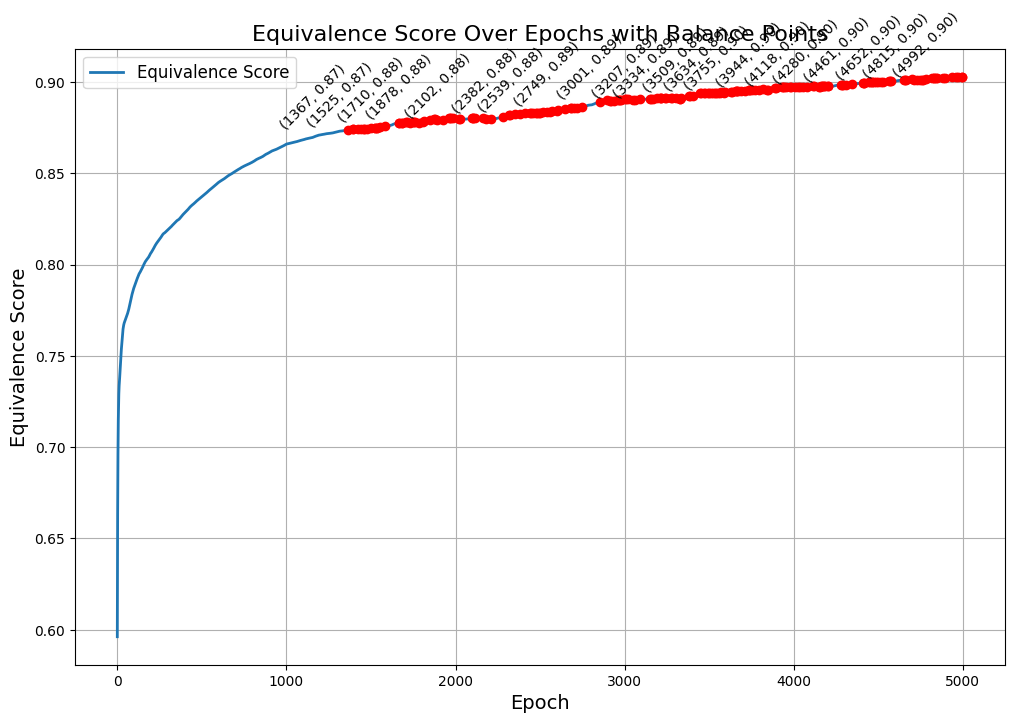

In [ ]:
# Identify balance points (local maxima)
def find_balance_points(equivalence_scores):
    balance_points = []
    for i in range(1, len(equivalence_scores) - 1):
        if equivalence_scores[i - 1] < equivalence_scores[i] > equivalence_scores[i + 1]:
            balance_points.append((i, equivalence_scores[i]))
    return balance_points

balance_points = find_balance_points(equivalence_scores)

# Print balance points
print("Balance Points:")
for point in balance_points:
    print(f"Epoch: {point[0]}, Equivalence Score: {point[1]:.2f}")

# Plot equivalence curve with balance points highlighted
plt.figure(figsize=(12, 8))
plt.plot(range(len(equivalence_scores)), equivalence_scores, label='Equivalence Score', linewidth=2)
for i, point in enumerate(balance_points):
    plt.plot(point[0], point[1], 'ro')  # Highlight balance points in red
    if i % 10 == 0:  # Display text every 10 points to avoid clutter
        plt.text(point[0], point[1], f'({point[0]}, {point[1]:.2f})', fontsize=10, ha='right', rotation=45)

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Equivalence Score', fontsize=14)
plt.title('Equivalence Score Over Epochs with Balance Points', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('equivalence_curve_with_balance_points.png')
plt.show()

# Advanced Methods About Equivalence

In [ ]:
import chess
import chess.svg
from IPython.display import display, clear_output, SVG
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import time
import random
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway

import os
import torch
import torch.nn as nn
import seaborn as sns
from kan import KAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import secrets

# Setting up constants
gamma = 0.95
batch_size = 32
target_update_freq = 10

# Define dimensions and adjustable parameters
dimensions = {
    'automorphic_forms': {
        'heuristic_weights': [0.5, 0.3, 0.2],  # Example weights for material, mobility, and control
    },
    'functoriality': {
        'randomization_level': 1.0,  # Degree of randomization
    },
    'symmetry': {
        'symmetry_coefficients': 1.0,  # Coefficient for symmetry utilization
    },
    'l_functions': {
        'learning_rate': 0.001,  # Learning rate for neural network training
        'dropout_rate': 0.5,  # Dropout rate in neural network layers
    }
}

# Function to adjust parameters
def adjust_parameters(parameters, adjustment_factors):
    for key, value in parameters.items():
        if isinstance(value, dict):
            adjust_parameters(value, adjustment_factors[key])
        elif isinstance(value, list):
            parameters[key] = [v * adjustment_factors[key] for v in value]
        else:
            parameters[key] *= adjustment_factors[key]
    return parameters

# Automorphic Heuristic Evaluation
def automorphic_heuristic_evaluation(board, weights):
    material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    mobility_count = len(list(board.legal_moves))
    piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())
    
    automorphic_score = sum([piece.square for piece in board.piece_map().values() if piece.color == chess.WHITE]) - sum([piece.square for piece in board.piece_map().values() if piece.color == chess.BLACK])
    automorphic_score = np.log(1 + abs(automorphic_score)) * (1 if automorphic_score > 0 else -1)
    
    score = weights[0] * material_count + weights[1] * mobility_count + weights[2] * piece_square_score + center_control_count + automorphic_score
    return score

# Functorial Transformation Framework
def transform_algorithm(algorithm, to_type, randomization_level):
    if to_type == 'deterministic':
        algorithm.type = 'deterministic'
        algorithm.policy = lambda q_values: np.argmax(q_values)
    elif to_type == 'probabilistic':
        algorithm.type = 'probabilistic'
        algorithm.policy = lambda q_values: softmax_policy(q_values, temperature=randomization_level)
    return algorithm

def softmax_policy(q_values, temperature):
    q_values = np.array(q_values)
    exp_values = np.exp(q_values / temperature)
    probabilities = exp_values / np.sum(exp_values)
    return np.random.choice(range(len(q_values)), p=probabilities)

# Symmetry and L-functions
def leverage_symmetry(board, coefficient):
    symmetry_score = 0
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            symmetry_score += piece.piece_type * (1 if piece.color == chess.WHITE else -1)
    symmetry_score = np.abs(symmetry_score) * coefficient
    return symmetry_score

def analyze_with_l_functions(data):
    non_zero_data = [d for d in data if d != 0]
    l_function_value = np.prod([1 / (1 - d) for d in non_zero_data])
    return l_function_value

In [ ]:
# Define the Game Environment
class ChessEnv:
    def __init__(self):
        self.board = chess.Board()
    
    def reset(self):
        self.board.reset()
        return self.board
    
    def step(self, state, action):
        self.board.push(action)
        reward = automorphic_heuristic_evaluation(self.board, dimensions['automorphic_forms']['heuristic_weights'])
        done = self.board.is_game_over()
        return self.board, reward, done
    
    def legal_moves(self, state):
        return list(state.legal_moves)
    
    def simulate_move(self, state, move):
        temp_board = state.copy()
        temp_board.push(move)
        return temp_board

# Define the Langlands NN Model
class LanglandsNN:
    def __init__(self, seed):
        self.model = self.build_model(seed)

    def build_model(self, seed):
        np.random.seed(seed)
        tf.random.set_seed(seed)
        model = Sequential([
            Flatten(input_shape=(8, 8, 12)),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=dimensions['l_functions']['learning_rate']), loss='mean_squared_error')
        return model

    def evaluate_board(self, board):
        board_state = self.board_to_input(board)
        return self.model.predict(board_state, verbose=0)[0][0]

    def board_to_input(self, board):
        input_array = np.zeros((8, 8, 12))
        piece_to_index = {
            'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
            'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
        }
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                x, y = divmod(square, 8)
                input_array[x, y, piece_to_index[piece.symbol()]] = 1
        return np.array([input_array])


In [ ]:
# Training Functions
def train_simple_nn(env, num_episodes=10, seed=42, temperature=1.0):
    nn = LanglandsNN(seed)
    set_random_seed(seed)
    
    for e in range(num_episodes):
        state = env.reset()
        done = False
        
        while not done:
            q_values = [nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
            action_index = softmax_policy(q_values, temperature)
            action = env.legal_moves(state)[action_index]
            next_state, reward, done = env.step(state, action)
            target = reward + automorphic_heuristic_evaluation(next_state, dimensions['automorphic_forms']['heuristic_weights'])
            state_input = nn.board_to_input(state)
            nn.model.fit(state_input, np.array([target]), epochs=1, verbose=0)
            state = next_state

    return nn

def update_nn(abel_nn, target_network, batch):
    states, actions, rewards, next_states, dones = zip(*batch)
    target_q_values = [target_network.evaluate_board(state) for state in next_states]
    targets = rewards + (1 - np.array(dones)) * np.array(target_q_values)
    states = np.array([abel_nn.board_to_input(state).reshape(-1, 8, 8, 12) for state in states])
    targets = np.array(targets).reshape(-1, 1)
    print(f"Updating NN: states shape: {states.shape}, targets shape: {targets.shape}")
    abel_nn.model.train_on_batch(np.vstack(states), targets)

def train_abel_nn_derandomized(env, num_episodes, seed, temperature):
    set_random_seed(seed)
    abel_nn = LanglandsNN(seed)
    target_network = LanglandsNN(seed)
    replay_buffer = []
    batch_size = 32
    target_update_freq = 10

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            q_values = [abel_nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
            action_index = softmax_policy(q_values, temperature)
            action = env.legal_moves(state)[action_index]
            next_state, reward, done = env.step(state, action)
            replay_buffer.append((state, action, reward, next_state, done))
            state = next_state
            
            if len(replay_buffer) > batch_size:
                batch = random.sample(replay_buffer, batch_size)
                update_nn(abel_nn, target_network, batch)
        
        if episode % target_update_freq == 0:
            target_network.model.set_weights(abel_nn.model.get_weights())
    
    return abel_nn


In [ ]:
# Simulate Games
def play_game_nn_probabilistic(abel_nn, env, max_moves=55, max_runtime=600, temperature=1.0):
    steps, times, material_counts, mobility_counts, piece_square_scores, center_control_counts, move_list, evaluation_scores, branching_factors, depths_of_search, move_diversities, exploration_vs_exploitations = [], [], [], [], [], [], [], [], [], [], [], []
    step_number = 1
    state = env.reset()
    start_time = time.time()

    while not env.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        q_values = [abel_nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
        action_index = softmax_policy(q_values, temperature)
        action = env.legal_moves(state)[action_index]
        next_state, reward, done = env.step(state, action)
        move_end_time = time.time()

        move_list.append(action.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)
        material_counts.append(reward)

        mobility_count = len(list(env.board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in env.board.piece_map().values())
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in env.board.piece_map().items())
        evaluation_score = abel_nn.evaluate_board(env.board)
        branching_factor = len(list(env.board.legal_moves))
        depth_of_search = 3
        move_diversity = np.var([reward, mobility_count, piece_square_score, center_control_count])
        exploration_vs_exploitation = 0

        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        state = next_state
        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=env.board, size=350)))
        time.sleep(1)
        print(f"Move: {action}, Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {reward}")

    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)
    print(f"Result: {env.board.result()}")
    return df

def play_game_nn_derandomized(abel_nn, env, max_moves=55, max_runtime=600, temperature=0.5):
    steps, times, material_counts, mobility_counts, piece_square_scores, center_control_counts, move_list, evaluation_scores, branching_factors, depths_of_search, move_diversities, exploration_vs_exploitations = [], [], [], [], [], [], [], [], [], [], [], []
    step_number = 1
    state = env.reset()
    start_time = time.time()

    while not env.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        q_values = [abel_nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
        action_index = softmax_policy(q_values, temperature)
        action = env.legal_moves(state)[action_index]
        next_state, reward, done = env.step(state, action)
        move_end_time = time.time()

        move_list.append(action.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)
        material_counts.append(reward)

        mobility_count = len(list(env.board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in env.board.piece_map().values())
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in env.board.piece_map().items())
        evaluation_score = abel_nn.evaluate_board(env.board)
        branching_factor = len(list(env.board.legal_moves))
        depth_of_search = 3
        move_diversity = np.var([reward, mobility_count, piece_square_score, center_control_count])
        exploration_vs_exploitation = 0

        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        state = next_state
        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=env.board, size=350)))
        time.sleep(1)
        print(f"Move: {action}, Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {reward}")

    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)
    print(f"Result: {env.board.result()}")
    return df


In [ ]:
# KAN Model and Training
class CustomKAN(nn.Module):
    def __init__(self, width, grid, k):
        super(CustomKAN, self).__init__()
        width_list = [[w, 0] for w in width]
        self.kan = KAN(width=width_list, grid=grid, k=k)
        self.dropout = nn.Dropout(p=dimensions['l_functions']['dropout_rate'])
        self.fc1 = nn.Linear(width[-1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.kan(x)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x.squeeze()

def normalize_data(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    std[std == 0] = 1
    return (data - mean) / std

def train_kan_model(train_input, train_label, val_input, val_label, test_input, test_label, num_epochs=5000):
    input_size = train_input.shape[1]
    model = CustomKAN(width=[input_size, 10, 5], grid=3, k=3)
    optimizer = torch.optim.Adam(model.parameters(), lr=dimensions['l_functions']['learning_rate'], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    train_losses = []
    val_accuracies = []
    test_accuracies = []
    equivalence_scores = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_input)
        loss = loss_fn(outputs, train_label.float())
        loss.backward()
        optimizer.step()
        scheduler.step()

        predicted = (outputs >= 0.5).float()
        correct = (predicted == train_label).sum().item()
        train_acc = correct / len(train_label)

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_input)
            val_predicted = (val_outputs >= 0.5).float()
            val_correct = (val_predicted == val_label).sum().item()
            val_acc = val_correct / len(val_label)

            test_outputs = model(test_input)
            test_predicted = (test_outputs >= 0.5).float()
            test_correct = (test_predicted == test_label).sum().item()
            test_acc = test_correct / len(test_label)

        train_losses.append(loss.item())
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)

        min_length = min(len(train_input), len(test_input))
        f_kan_a = model(train_input[:min_length]).detach().numpy()
        f_kan_b = model(test_input[:min_length]).detach().numpy()
        numerator = np.linalg.norm(f_kan_a - f_kan_b)
        denominator = np.linalg.norm(f_kan_a) + np.linalg.norm(f_kan_b)
        equivalence_score = 1 - (numerator / denominator)
        equivalence_scores.append(equivalence_score)

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}, Equivalence Score: {equivalence_score:.4f}')

    return model, equivalence_scores


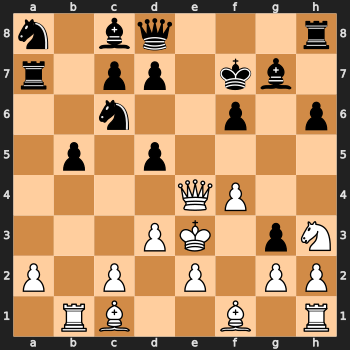

Move: b4e4, Step: 56, Time: 1.2015047073364258, Material: 33
Result: *
checkpoint directory created: ./model
saving model version 0.0
Epoch [100/5000], Loss: 0.0150, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7178
Epoch [200/5000], Loss: 0.0057, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7382
Epoch [300/5000], Loss: 0.0023, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7521
Epoch [400/5000], Loss: 0.0011, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7653
Epoch [500/5000], Loss: 0.0012, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7752
Epoch [600/5000], Loss: 0.0014, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7854
Epoch [700/5000], Loss: 0.0004, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equ

In [ ]:
# Compare Abel Versions
def ensure_dataframe(data):
    if isinstance(data, pd.DataFrame):
        return data
    return pd.DataFrame(data)

def compare_abel_versions(probabilistic_nn, derandomized_nn, env, games=3, max_moves=55, max_runtime=300):
    probabilistic_results = []
    derandomized_results = []

    for _ in range(games):
        env.reset()
        probabilistic_data = play_game_nn_probabilistic(probabilistic_nn, env, max_moves, max_runtime)
        probabilistic_results.append(probabilistic_data)

        env.reset()
        derandomized_data = play_game_nn_derandomized(derandomized_nn, env, max_moves, max_runtime)
        derandomized_results.append(derandomized_data)

    probabilistic_results = [ensure_dataframe(df) for df in probabilistic_results]
    derandomized_results = [ensure_dataframe(df) for df in derandomized_results]

    numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                       'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                       'Exploration vs Exploitation']

    combined_probabilistic_data = pd.concat(probabilistic_results, ignore_index=True)
    combined_derandomized_data = pd.concat(derandomized_results, ignore_index=True)

    combined_probabilistic_normalized = normalize_data(combined_probabilistic_data[numeric_columns].values)
    combined_derandomized_normalized = normalize_data(combined_derandomized_data[numeric_columns].values)

    input_dim = combined_probabilistic_normalized.shape[1]
    train_input, val_input, train_label, val_label = train_test_split(
        combined_probabilistic_normalized, np.ones(len(combined_probabilistic_normalized)), test_size=0.2, random_state=42)
    test_input = combined_derandomized_normalized
    test_label = np.zeros(len(test_input))

    train_input = torch.from_numpy(train_input).float()
    val_input = torch.from_numpy(val_input).float()
    test_input = torch.from_numpy(test_input).float()
    train_label = torch.from_numpy(train_label).long()
    val_label = torch.from_numpy(val_label).long()
    test_label = torch.from_numpy(test_label).long()

    kan_model, equivalence_scores = train_kan_model(train_input, train_label, val_input, val_label, test_input, test_label)

    return probabilistic_results, derandomized_results, kan_model, equivalence_scores

# Compare the two versions over multiple games
probabilistic_results, derandomized_results, kan_model, equivalence_scores = compare_abel_versions(abel_nn_probabilistic, abel_nn_derandomized, env, games=5)


Probabilistic NN Mean Metrics:
 Material Count                  31.167273
Mobility Count                  29.756364
Piece-Square Score               0.072727
Center Control Count             1.265455
Evaluation Score                46.238392
Branching Factor                29.756364
Depth of Search                  3.000000
Move Diversity                 232.978636
Exploration vs Exploitation      0.000000
dtype: float64
Probabilistic NN Std Metrics:
 Material Count                  6.871688
Mobility Count                  6.438558
Piece-Square Score              0.514553
Center Control Count            0.698334
Evaluation Score                4.197485
Branching Factor                6.438558
Depth of Search                 0.000000
Move Diversity                 89.420877
Exploration vs Exploitation     0.000000
dtype: float64

Derandomized NN Mean Metrics:
 Material Count                  27.749091
Mobility Count                  27.523636
Piece-Square Score              -0.138182
Ce

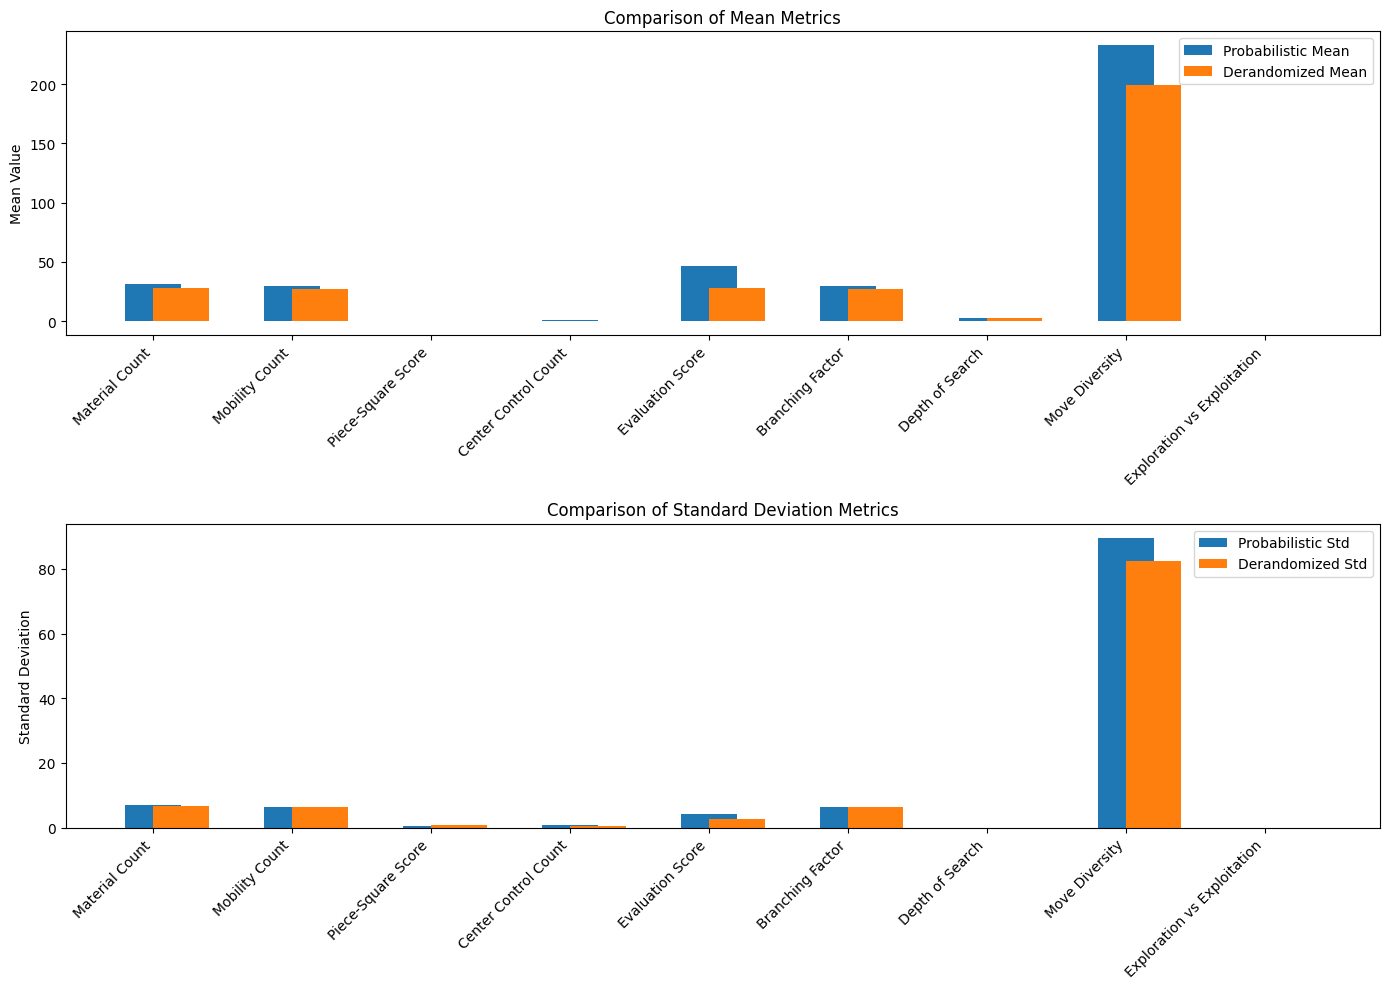

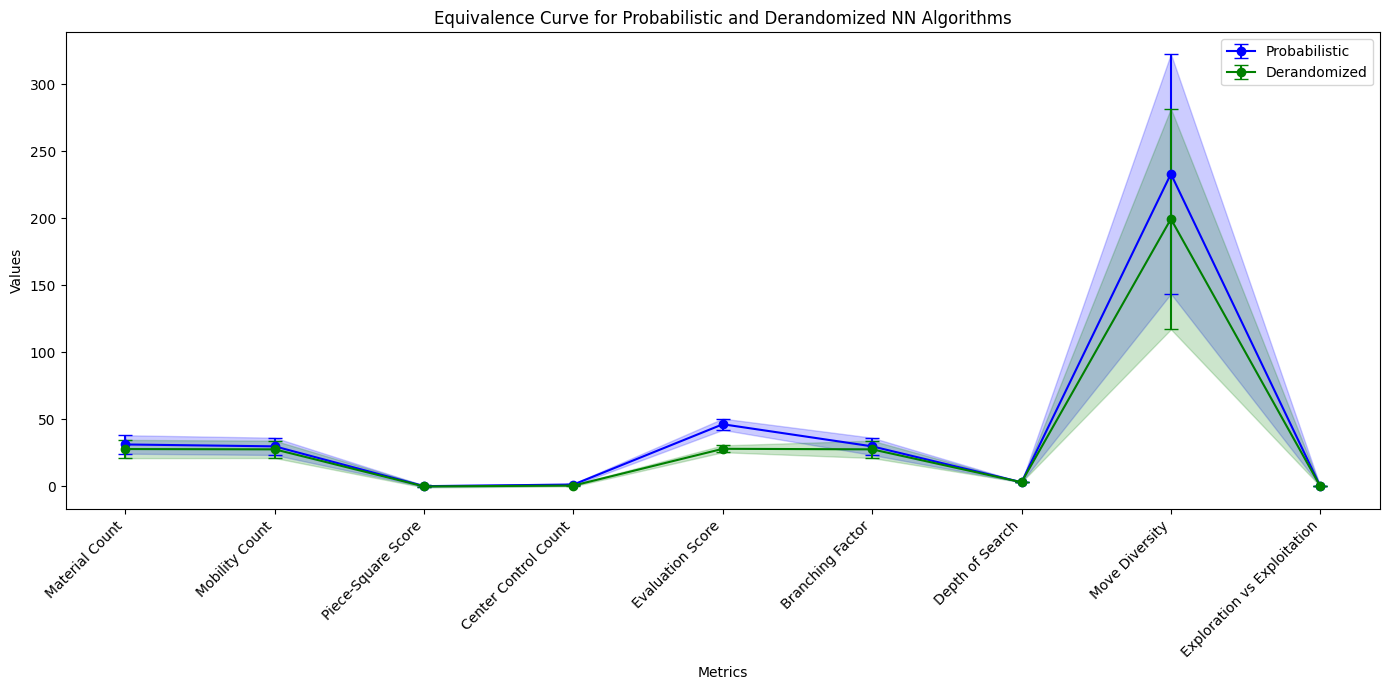

In [ ]:
# Aggregate Data and Calculate Metrics
def aggregate_metrics(results):
    numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                       'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                       'Exploration vs Exploitation']
    aggregated_data = pd.concat(results, ignore_index=True)
    mean_metrics = aggregated_data[numeric_columns].mean()
    std_metrics = aggregated_data[numeric_columns].std()
    return mean_metrics, std_metrics, aggregated_data

probabilistic_results = [ensure_dataframe(df) for df in probabilistic_results]
derandomized_results = [ensure_dataframe(df) for df in derandomized_results]

probabilistic_mean, probabilistic_std, probabilistic_data = aggregate_metrics(probabilistic_results)
derandomized_mean, derandomized_std, derandomized_data = aggregate_metrics(derandomized_results)

print("Probabilistic NN Mean Metrics:\n", probabilistic_mean)
print("Probabilistic NN Std Metrics:\n", probabilistic_std)
print("\nDerandomized NN Mean Metrics:\n", derandomized_mean)
print("Derandomized NN Std Metrics:\n", derandomized_std)

print("\nProbabilistic Moves:\n", probabilistic_data['Move'])
print("\nDerandomized Moves:\n", derandomized_data['Move'])

# Plot Comparison Metrics and Equivalence Curve
def plot_comparison_metrics(probabilistic_mean, probabilistic_std, derandomized_mean, derandomized_std):
    metrics = probabilistic_mean.index
    x = range(len(metrics))

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    axs[0].bar(x, probabilistic_mean, width=0.4, label='Probabilistic Mean', align='center')
    axs[0].bar(x, derandomized_mean, width=0.4, label='Derandomized Mean', align='edge')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(metrics, rotation=45, ha='right')
    axs[0].set_ylabel('Mean Value')
    axs[0].set_title('Comparison of Mean Metrics')
    axs[0].legend()

    axs[1].bar(x, probabilistic_std, width=0.4, label='Probabilistic Std', align='center')
    axs[1].bar(x, derandomized_std, width=0.4, label='Derandomized Std', align='edge')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(metrics, rotation=45, ha='right')
    axs[1].set_ylabel('Standard Deviation')
    axs[1].set_title('Comparison of Standard Deviation Metrics')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_comparison_metrics(probabilistic_mean, probabilistic_std, derandomized_mean, derandomized_std)

def plot_equivalence_curve(probabilistic_mean, probabilistic_std, derandomized_mean, derandomized_std, equivalence_scores):
    metrics = probabilistic_mean.index
    x = np.arange(len(metrics))

    fig, ax = plt.subplots(figsize=(14, 7))

    ax.errorbar(x, probabilistic_mean, yerr=probabilistic_std, fmt='o-', label='Probabilistic', color='blue', capsize=5)
    ax.errorbar(x, derandomized_mean, yerr=derandomized_std, fmt='o-', label='Derandomized', color='green', capsize=5)
    ax.fill_between(x, probabilistic_mean - probabilistic_std, probabilistic_mean + probabilistic_std, color='blue', alpha=0.2)
    ax.fill_between(x, derandomized_mean - derandomized_std, derandomized_mean + derandomized_std, color='green', alpha=0.2)

    ax.set_title('Equivalence Curve for Probabilistic and Derandomized NN Algorithms')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

plot_equivalence_curve(probabilistic_mean, probabilistic_std, derandomized_mean, derandomized_std, equivalence_scores)


/tmp/ipykernel_665/4258657682.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value_t = ttest_ind(probabilistic_data[metric], derandomized_data[metric], equal_var=False)
/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/stats/_stats_py.py:3906: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
Material Count: t-statistic = 5.860876183759845, p-value (t-test) = 7.955514813354506e-09
Material Count: f-statistic = 34.349869641363355, p-value (F-test) = 7.955127830937017e-09

Mobility Count: t-statistic = 4.060938801227609, p-value (t-test) = 5.600488505527596e-05
Mobility Count: f-statistic = 16.491223947315905, p-value (F-test) = 5.600483329060128e-05

Piece-Square Score: t-statistic = 3.806748914129184, p-value (t-test) = 0.000158991955623

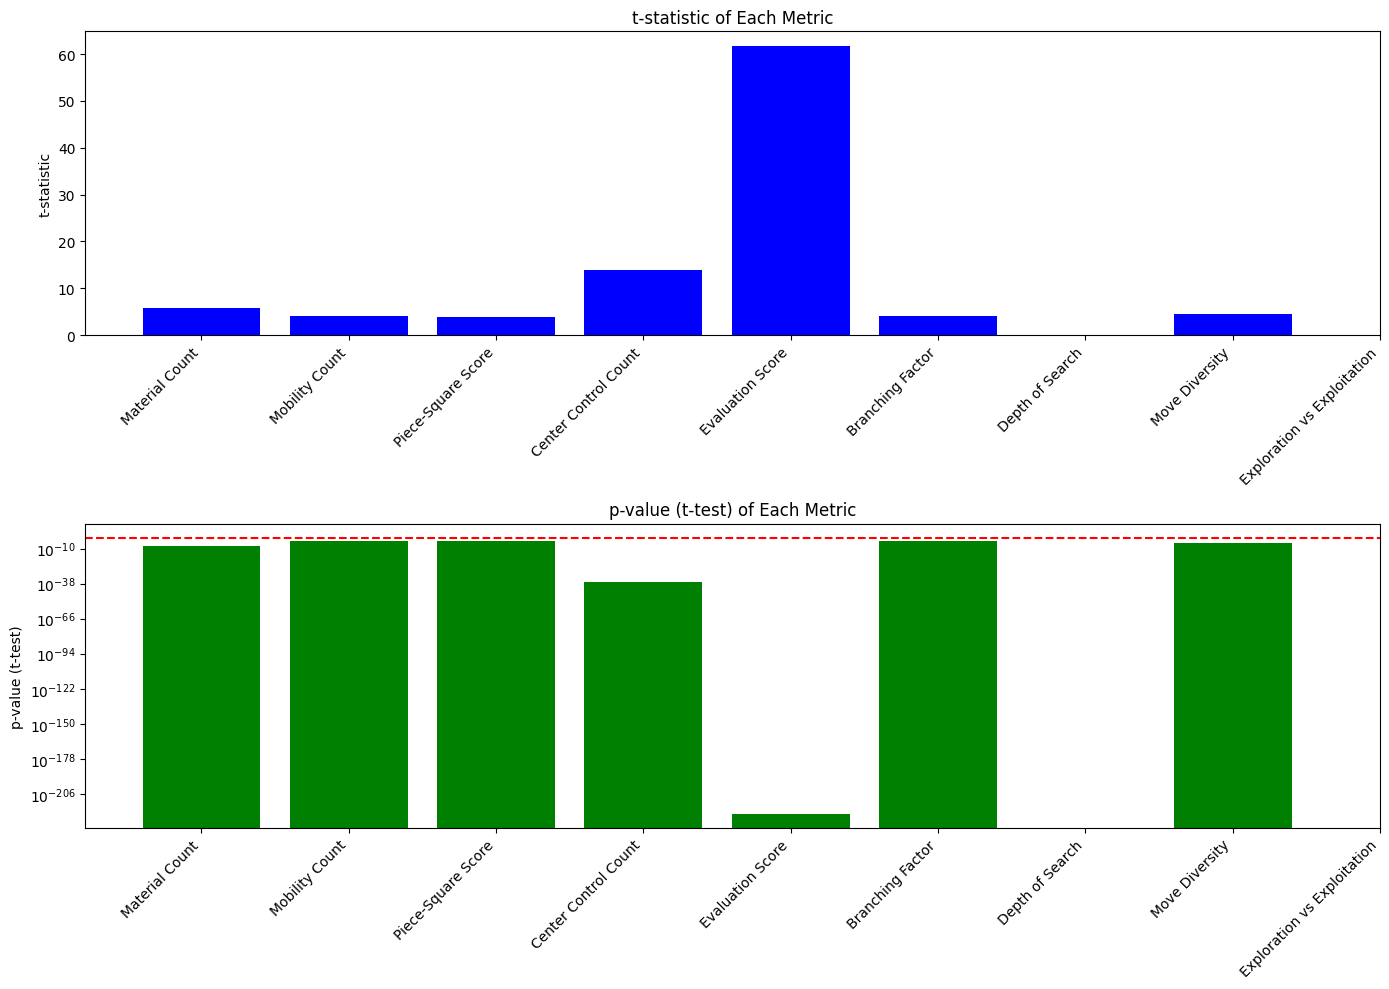

In [ ]:
# Perform Statistical Tests
from scipy.stats import ttest_ind, f_oneway

def perform_statistical_tests(probabilistic_data, derandomized_data):
    results = {}
    for metric in probabilistic_data.columns:
        if metric in ['Move', 'Step', 'Time']:
            continue
        t_stat, p_value_t = ttest_ind(probabilistic_data[metric], derandomized_data[metric], equal_var=False)
        f_stat, p_value_f = f_oneway(probabilistic_data[metric], derandomized_data[metric])
        results[metric] = {
            't_stat': t_stat,
            'p_value_t': p_value_t,
            'f_stat': f_stat,
            'p_value_f': p_value_f
        }
    return results

statistical_results = perform_statistical_tests(probabilistic_data, derandomized_data)

for metric, result in statistical_results.items():
    print(f"{metric}: t-statistic = {result['t_stat']}, p-value (t-test) = {result['p_value_t']}")
    print(f"{metric}: f-statistic = {result['f_stat']}, p-value (F-test) = {result['p_value_f']}\n")

def plot_statistical_analysis(statistical_results):
    metrics = list(statistical_results.keys())
    t_stats = [result['t_stat'] for result in statistical_results.values()]
    p_values_t = [result['p_value_t'] for result in statistical_results.values()]

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    axs[0].bar(metrics, t_stats, color='blue')
    axs[0].set_xticks(metrics)
    axs[0].set_xticklabels(metrics, rotation=45, ha='right')
    axs[0].set_ylabel('t-statistic')
    axs[0].set_title('t-statistic of Each Metric')

    axs[1].bar(metrics, p_values_t, color='green')
    axs[1].set_xticks(metrics)
    axs[1].set_xticklabels(metrics, rotation=45, ha='right')
    axs[1].axhline(y=0.05, color='r', linestyle='--')
    axs[1].set_ylabel('p-value (t-test)')
    axs[1].set_title('p-value (t-test) of Each Metric')
    axs[1].set_yscale('log') 

    plt.tight_layout()
    plt.show()

plot_statistical_analysis(statistical_results)


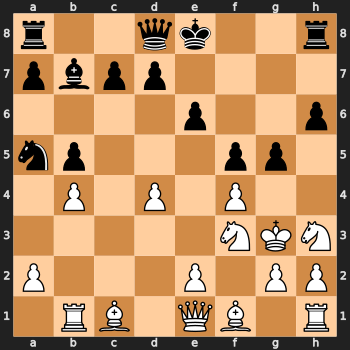

Move: d1e1, Step: 56, Time: 1.068763256072998, Material: 33
Result: *
checkpoint directory created: ./model
saving model version 0.0
Epoch [100/5000], Loss: 0.0186, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7173
Epoch [200/5000], Loss: 0.0054, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7421
Epoch [300/5000], Loss: 0.0018, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7623
Epoch [400/5000], Loss: 0.0015, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7768
Epoch [500/5000], Loss: 0.0014, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7878
Epoch [600/5000], Loss: 0.0007, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7983
Epoch [700/5000], Loss: 0.0007, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equi

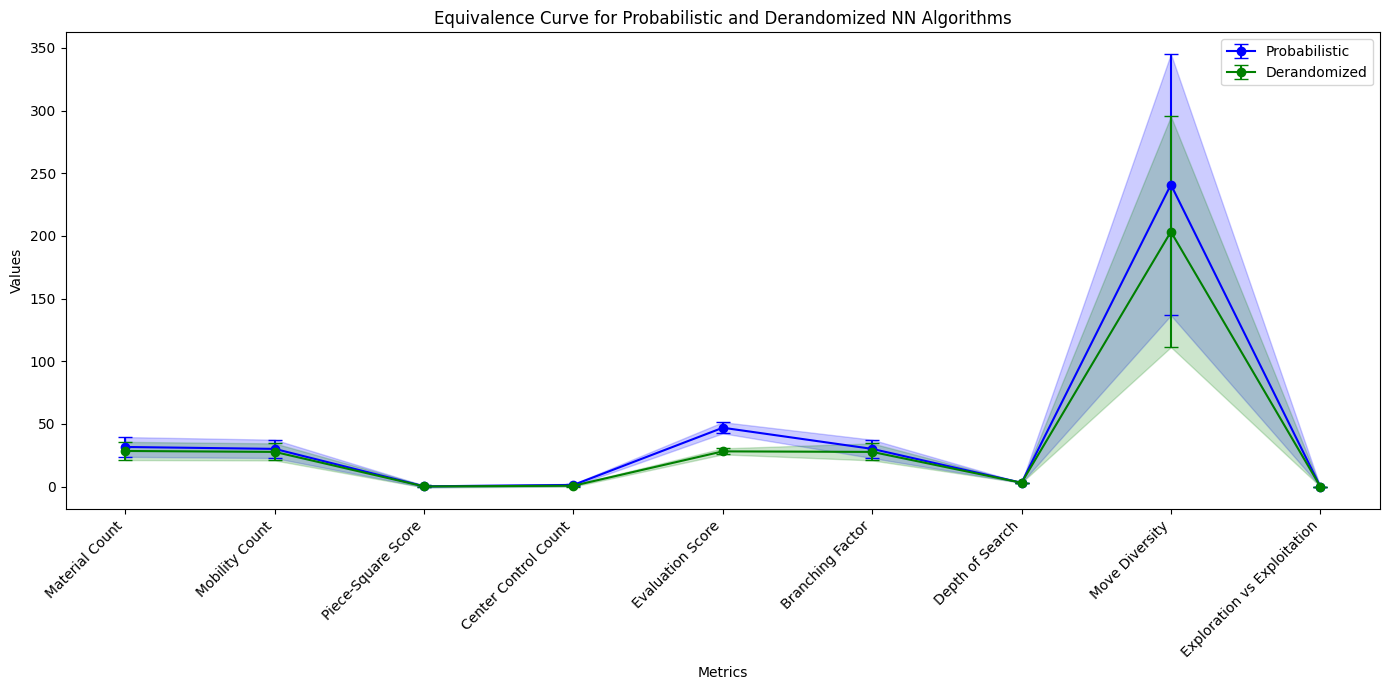

In [ ]:
# Additional Games and Combined Metrics
additional_games = 15
probabilistic_results_additional, derandomized_results_additional, _, _ = compare_abel_versions(abel_nn_probabilistic, abel_nn_derandomized, env, games=additional_games)

probabilistic_results_additional = [ensure_dataframe(df) for df in probabilistic_results_additional]
derandomized_results_additional = [ensure_dataframe(df) for df in derandomized_results_additional]

probabilistic_mean_additional, probabilistic_std_additional, probabilistic_data_additional = aggregate_metrics(probabilistic_results_additional)
derandomized_mean_additional, derandomized_std_additional, derandomized_data_additional = aggregate_metrics(derandomized_results_additional)

combined_probabilistic_data = pd.concat([probabilistic_data, probabilistic_data_additional], ignore_index=True)
combined_derandomized_data = pd.concat([derandomized_data, derandomized_data_additional], ignore_index=True)

combined_probabilistic_mean, combined_probabilistic_std, _ = aggregate_metrics([combined_probabilistic_data])
combined_derandomized_mean, combined_derandomized_std, _ = aggregate_metrics([combined_derandomized_data])

print("Combined Probabilistic Mean Metrics:\n", combined_probabilistic_mean)
print("Combined Probabilistic Std Metrics:\n", combined_probabilistic_std)
print("\nCombined Derandomized Mean Metrics:\n", combined_derandomized_mean)
print("Combined Derandomized Std Metrics:\n", combined_derandomized_std)

plot_equivalence_curve(combined_probabilistic_mean, combined_probabilistic_std, combined_derandomized_mean, combined_derandomized_std, equivalence_scores)


/tmp/ipykernel_665/1692885610.py:12: RuntimeWarning: invalid value encountered in divide
  normalized_data = (data - mean) / std
/tmp/ipykernel_665/1692885610.py:12: RuntimeWarning: invalid value encountered in divide
  normalized_data = (data - mean) / std


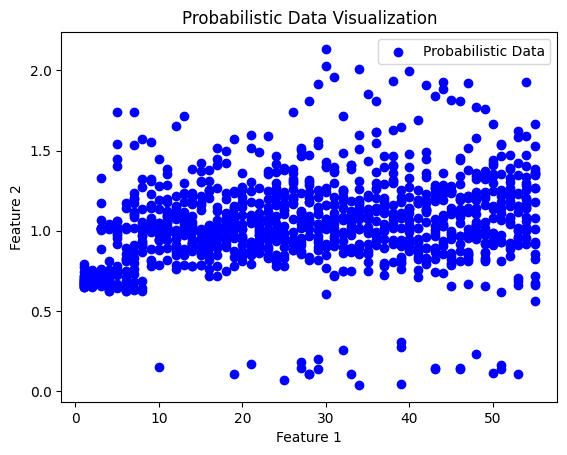

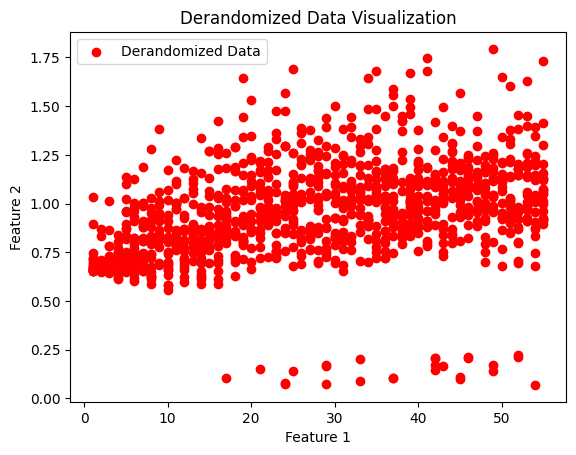

Symbolic Formula: ([0, 0, 0, 0, 0], [x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9])


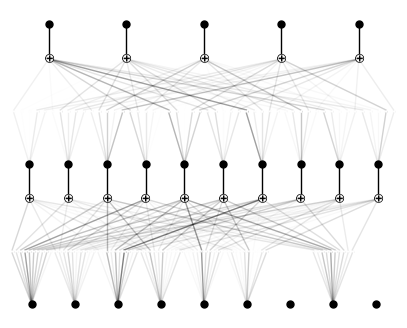

Train Predictions Shape: (880,)
Test Predictions Shape: (1100,)
Train Predictions: [17.221653  17.839382  14.547011  14.602799  13.112272  26.322737
 19.405941  12.999122  15.718793  17.04403   18.78517   14.892711
 14.371385  15.209326  16.503607  23.617834  15.777706  14.222466
 18.563875  16.503607  22.848333  17.162346  14.963606  18.89612
 14.045508  17.801008  13.171374  19.487665  16.097256  18.416262
 12.694124  14.602799  18.13841   13.025286  14.85453   17.727365
 17.818735  14.198691  13.146138  17.311197  15.277217  18.64998
 21.183073  16.455103  12.877752  18.322372  17.204409  16.488733
 16.987913  12.485617  21.268707  17.77269   14.99288   14.464767
 12.567678  14.791678  13.044105  13.999631  18.171812  13.606732
 17.835184  20.46645   15.604142  17.956205  14.197942  15.813127
 14.518896  18.145332  15.503008  13.141891  17.818735  13.823058
 12.3496895 13.751306  19.709894  19.75786   17.242237  16.663143
 17.65789   18.987547  16.227823  13.007294  14.003505  10.59

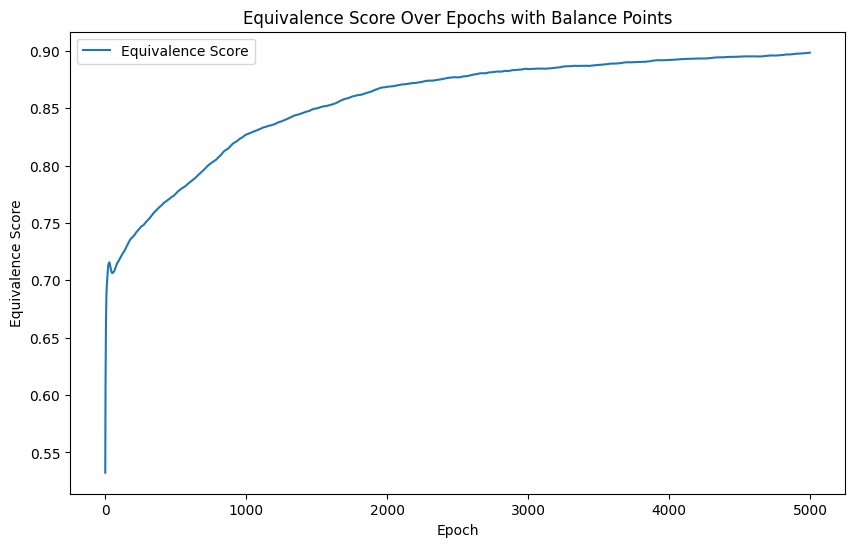

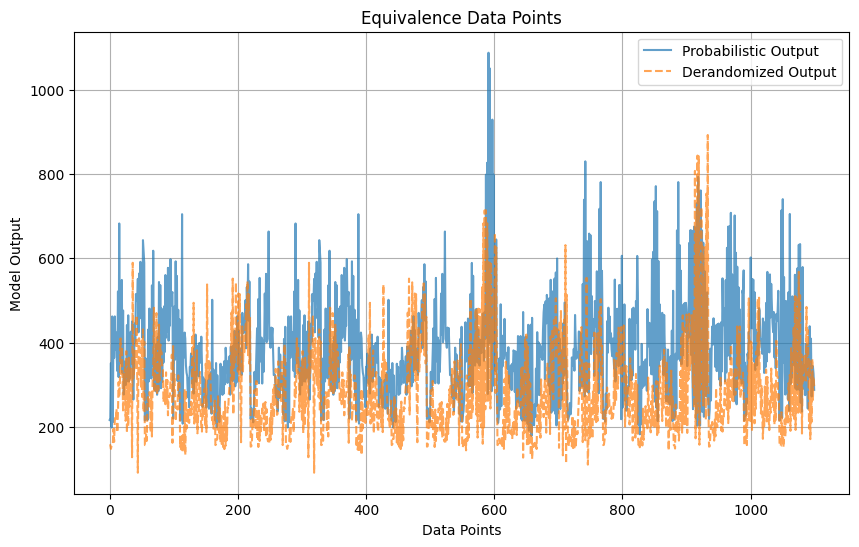

Available keys in the model's state dictionary: ['node_bias_0', 'node_scale_0', 'subnode_bias_0', 'subnode_scale_0', 'node_bias_1', 'node_scale_1', 'subnode_bias_1', 'subnode_scale_1', 'act_fun.0.grid', 'act_fun.0.coef', 'act_fun.0.scale_base', 'act_fun.0.scale_sp', 'act_fun.0.mask', 'act_fun.1.grid', 'act_fun.1.coef', 'act_fun.1.scale_base', 'act_fun.1.scale_sp', 'act_fun.1.mask', 'symbolic_fun.0.mask', 'symbolic_fun.0.affine', 'symbolic_fun.1.mask', 'symbolic_fun.1.affine']


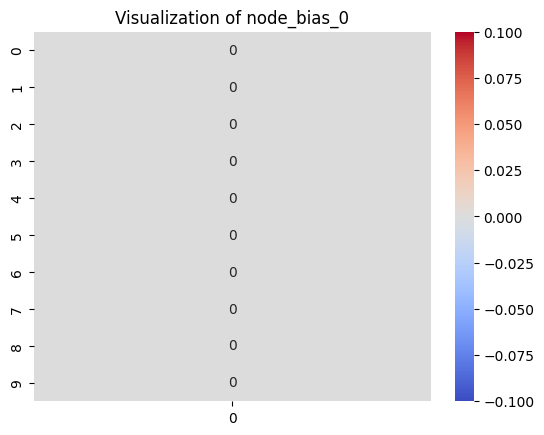

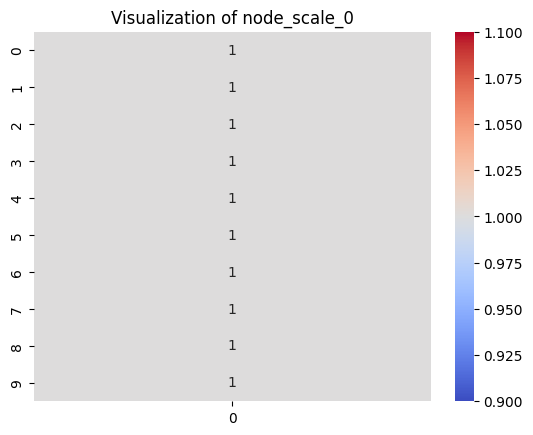

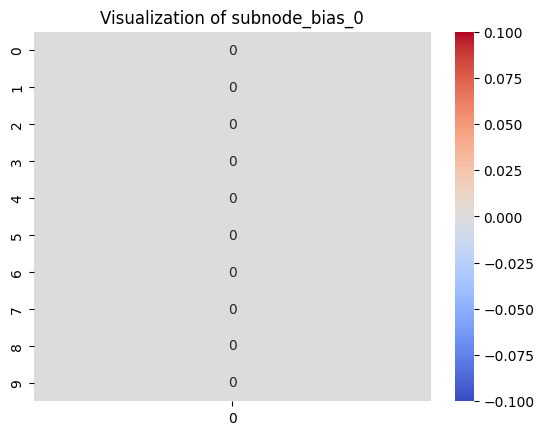

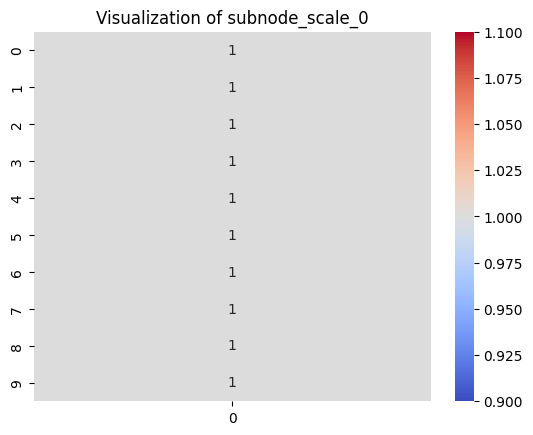

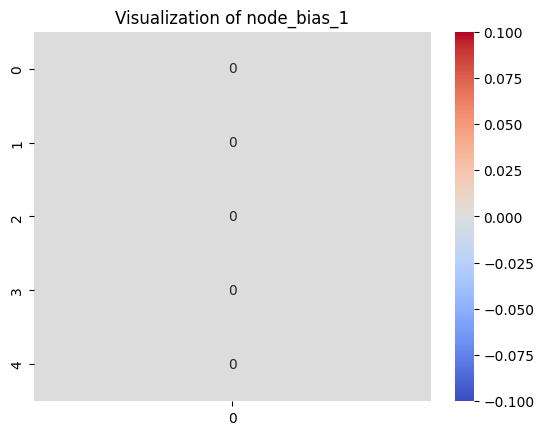

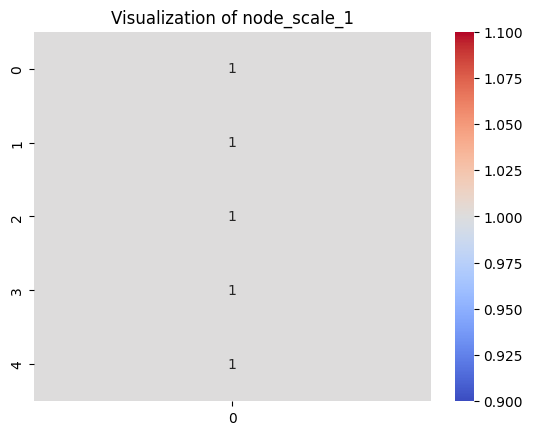

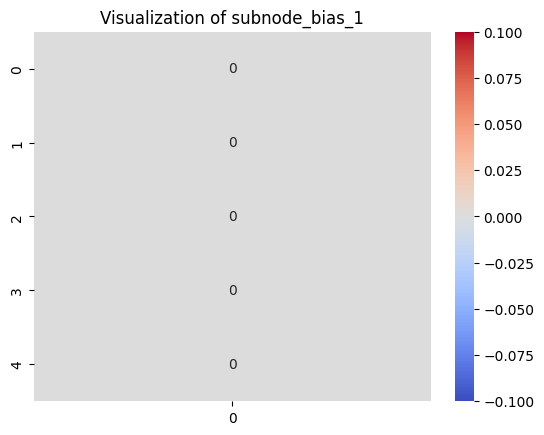

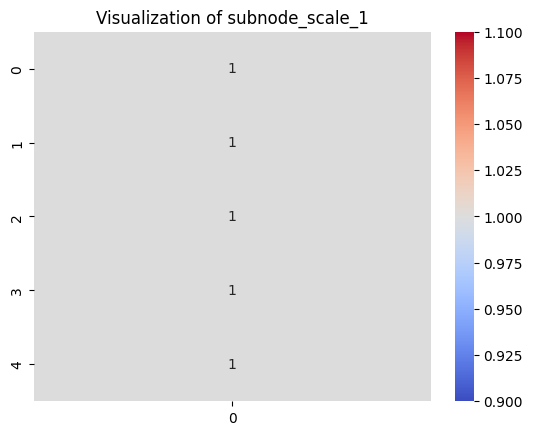

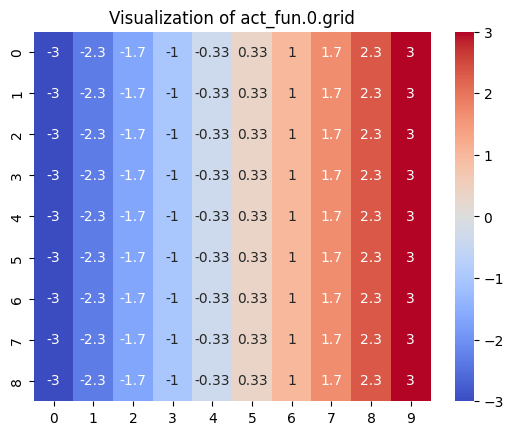

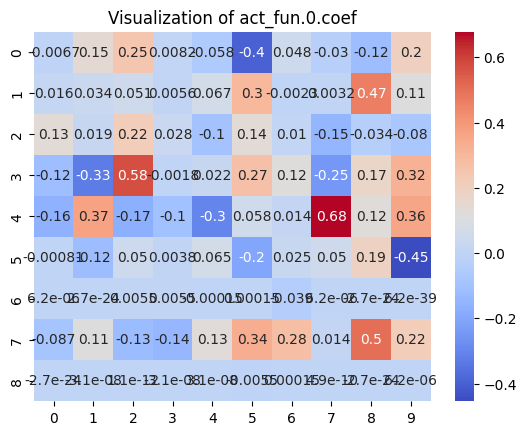

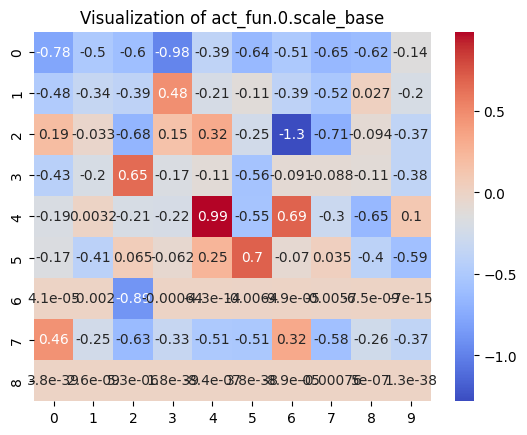

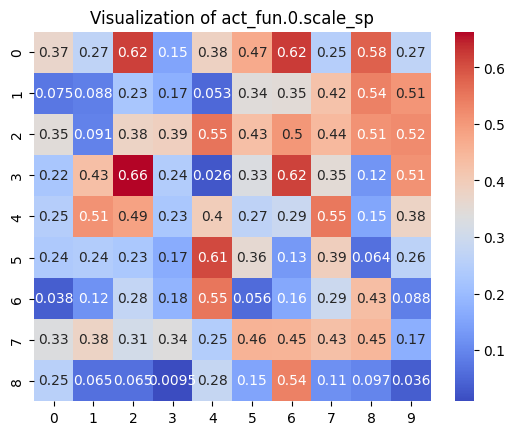

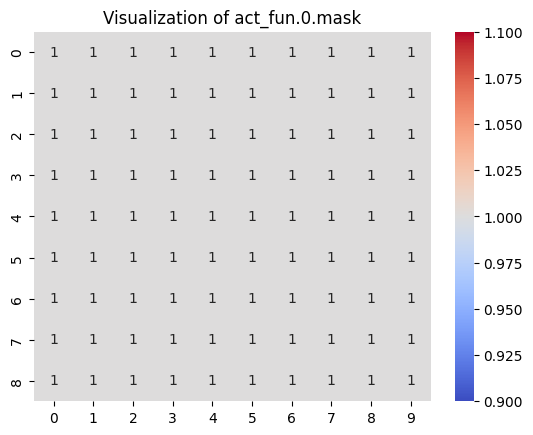

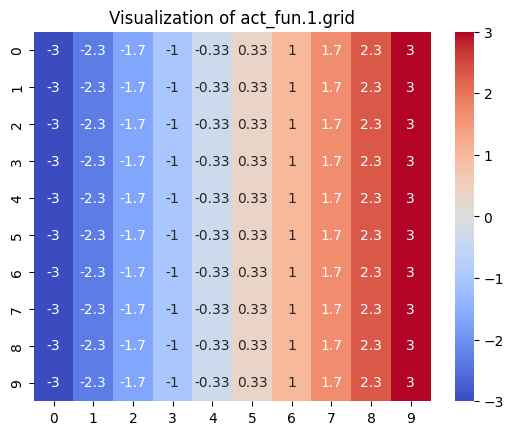

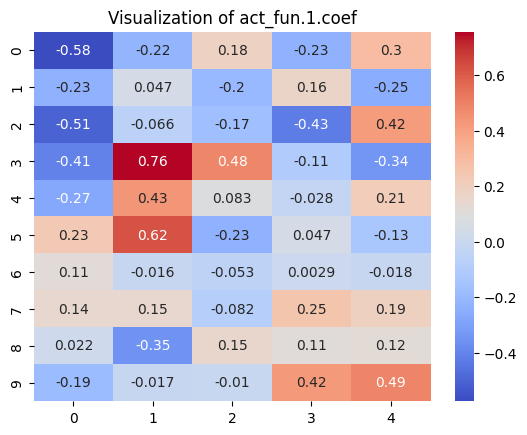

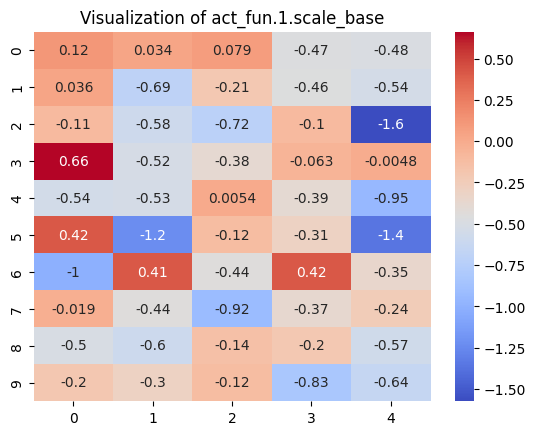

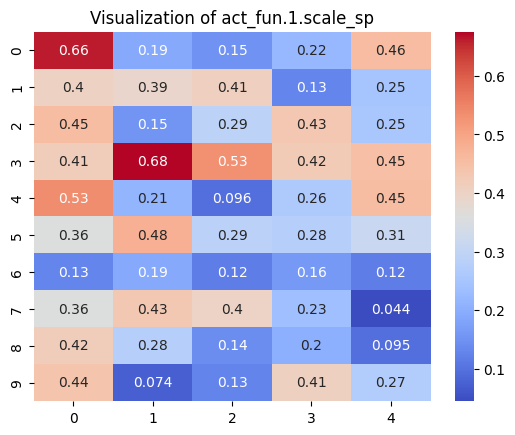

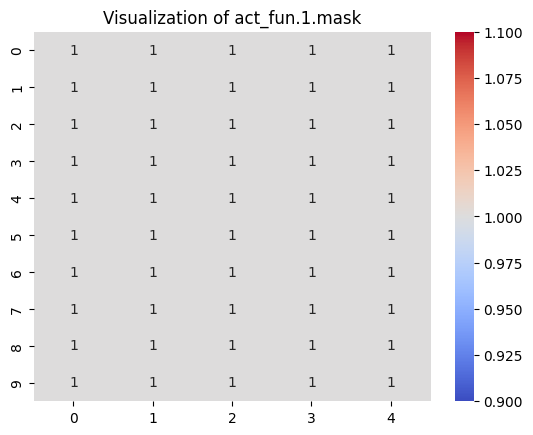

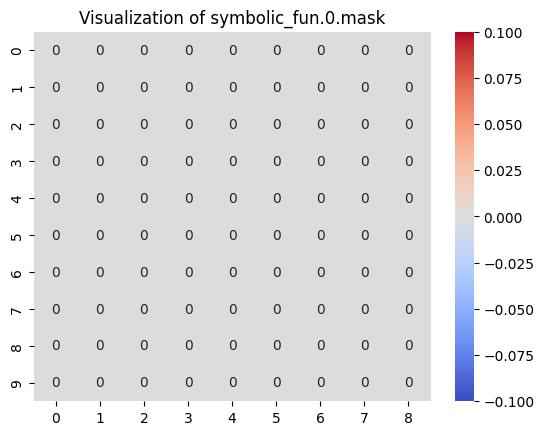

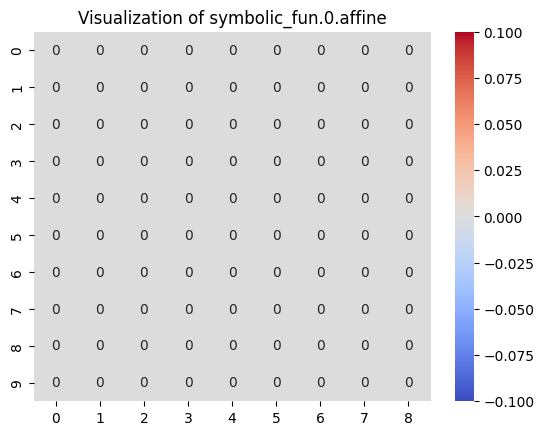

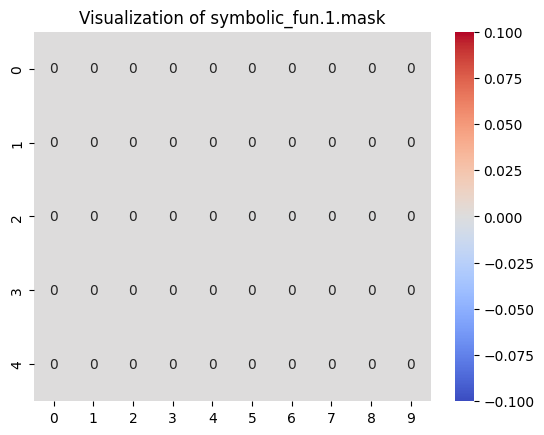

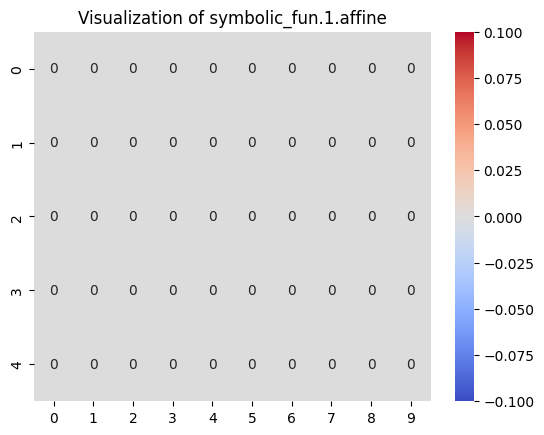

In [ ]:
# Visualize and Extract Results from KAN Model
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split

def normalize_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normalized_data = (data - mean) / std
    normalized_data = np.nan_to_num(normalized_data)
    return normalized_data

numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                   'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                   'Exploration vs Exploitation']

train_input = torch.from_numpy(normalize_data(combined_probabilistic_data[numeric_columns].values.astype(np.float32)))
test_input = torch.from_numpy(normalize_data(combined_derandomized_data[numeric_columns].values.astype(np.float32)))
train_label = torch.from_numpy(np.ones(len(train_input))).float()
test_label = torch.from_numpy(np.zeros(len(test_input))).float()

train_input, val_input, train_label, val_label = train_test_split(train_input.numpy(), train_label.numpy(), test_size=0.2, random_state=42)

train_input = torch.from_numpy(train_input)
val_input = torch.from_numpy(val_input)
train_label = torch.from_numpy(train_label)
val_label = torch.from_numpy(val_label)

plt.scatter(combined_probabilistic_data.iloc[:, 0], combined_probabilistic_data.iloc[:, 1], c='blue', label='Probabilistic Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Probabilistic Data Visualization')
plt.legend()
plt.show()

plt.scatter(combined_derandomized_data.iloc[:, 0], combined_derandomized_data.iloc[:, 1], c='red', label='Derandomized Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Derandomized Data Visualization')
plt.legend()
plt.show()

img_src_path = '/work/pykan/kan/assets/img/sum_symbol.png'
img_dest_path = '/root/venv/lib/python3.9/site-packages/kan/assets/img/sum_symbol.png'
if not os.path.exists(img_dest_path):
    os.makedirs(os.path.dirname(img_dest_path), exist_ok=True)
    os.system(f'cp {img_src_path} {img_dest_path}')

symbolic_formula = kan_model.kan.symbolic_formula()
print(f'Symbolic Formula: {symbolic_formula}')

try:
    kan_model.kan.plot()
    plt.show()
except FileNotFoundError as e:
    print(f"Error plotting model: {e}")
except ValueError as e:
    print(f"Value error while plotting model: {e}")

train_predictions = kan_model(train_input.float()).detach().numpy()
test_predictions = kan_model(test_input.float()).detach().numpy()

print("Train Predictions Shape:", train_predictions.shape)
print("Test Predictions Shape:", test_predictions.shape)
print("Train Predictions:", train_predictions)
print("Test Predictions:", test_predictions)

plt.figure(figsize=(10, 6))
plt.plot(range(len(equivalence_scores)), equivalence_scores, label='Equivalence Score')
plt.xlabel('Epoch')
plt.ylabel('Equivalence Score')
plt.title('Equivalence Score')
plt.legend()
plt.savefig('equivalence_curve_with_balance_points.png')
plt.show()

probabilistic_data_array = combined_probabilistic_data[numeric_columns].values.astype(np.float32)
derandomized_data_array = combined_derandomized_data[numeric_columns].values.astype(np.float32)

probabilistic_data_points = kan_model(torch.from_numpy(probabilistic_data_array).float()).detach().numpy()
derandomized_data_points = kan_model(torch.from_numpy(derandomized_data_array).float()).detach().numpy()

probabilistic_data_points = probabilistic_data_points.flatten()
derandomized_data_points = derandomized_data_points.flatten()

min_length = min(len(probabilistic_data_points), len(derandomized_data_points))
probabilistic_data_points = probabilistic_data_points[:min_length]
derandomized_data_points = derandomized_data_points[:min_length]

plt.figure(figsize=(10, 6))
plt.plot(probabilistic_data_points, label='Probabilistic Output', linestyle='-', alpha=0.7)
plt.plot(derandomized_data_points, label='Derandomized Output', linestyle='--', alpha=0.7)
plt.xlabel('Data Points')
plt.ylabel('Model Output')
plt.title('Equivalence Data Points')
plt.legend()
plt.grid(True)
plt.savefig('equivalence_data_points_detailed.png')
plt.show()

weights = kan_model.kan.state_dict()

keys = list(weights.keys())
print("Available keys in the model's state dictionary:", keys)

def visualize_weights(key):
    data = weights[key].detach().numpy()
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    elif data.ndim == 3:
        data = data[:, :, 0]
    sns.heatmap(data, annot=True, cmap='coolwarm')
    plt.title(f'Visualization of {key}')
    plt.show()

for key in keys:
    visualize_weights(key)



Balance Points:
Epoch: 29, Equivalence Score: 0.72
Epoch: 1545, Equivalence Score: 0.85
Epoch: 1701, Equivalence Score: 0.86
Epoch: 1796, Equivalence Score: 0.86
Epoch: 1810, Equivalence Score: 0.86
Epoch: 1968, Equivalence Score: 0.87
Epoch: 1974, Equivalence Score: 0.87
Epoch: 1978, Equivalence Score: 0.87
Epoch: 2023, Equivalence Score: 0.87
Epoch: 2108, Equivalence Score: 0.87
Epoch: 2178, Equivalence Score: 0.87
Epoch: 2190, Equivalence Score: 0.87
Epoch: 2285, Equivalence Score: 0.87
Epoch: 2288, Equivalence Score: 0.87
Epoch: 2299, Equivalence Score: 0.87
Epoch: 2330, Equivalence Score: 0.87
Epoch: 2434, Equivalence Score: 0.88
Epoch: 2465, Equivalence Score: 0.88
Epoch: 2480, Equivalence Score: 0.88
Epoch: 2500, Equivalence Score: 0.88
Epoch: 2546, Equivalence Score: 0.88
Epoch: 2549, Equivalence Score: 0.88
Epoch: 2659, Equivalence Score: 0.88
Epoch: 2674, Equivalence Score: 0.88
Epoch: 2698, Equivalence Score: 0.88
Epoch: 2728, Equivalence Score: 0.88
Epoch: 2730, Equivalence

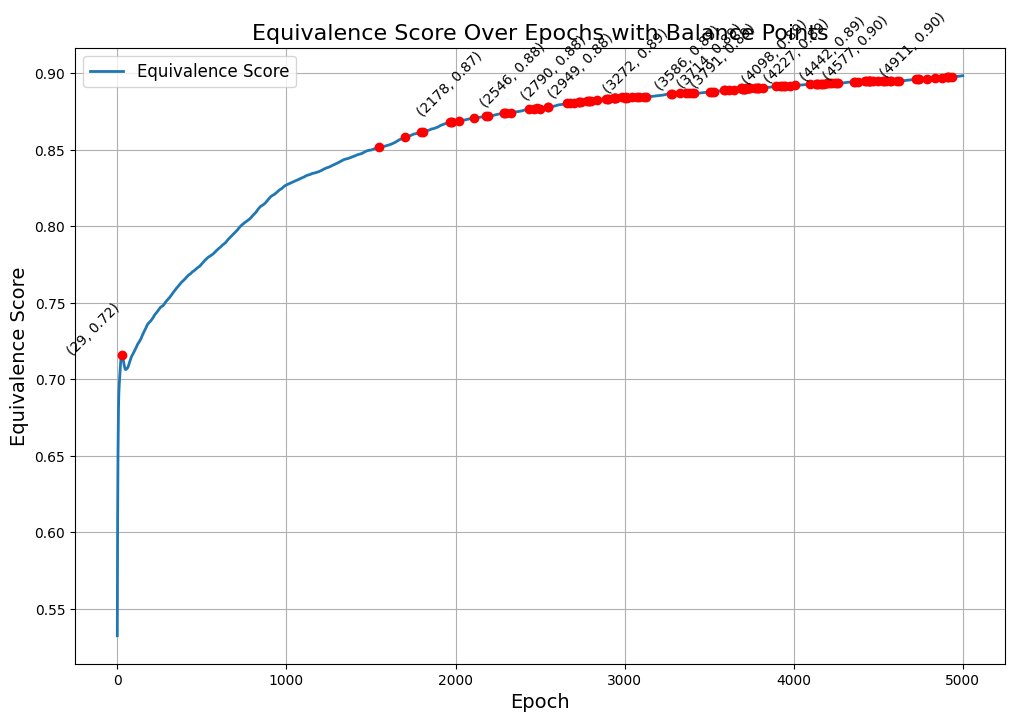

In [ ]:
# Identify balance points (local maxima)
def find_balance_points(equivalence_scores):
    balance_points = []
    for i in range(1, len(equivalence_scores) - 1):
        if equivalence_scores[i - 1] < equivalence_scores[i] > equivalence_scores[i + 1]:
            balance_points.append((i, equivalence_scores[i]))
    return balance_points

balance_points = find_balance_points(equivalence_scores)

# Print balance points
print("Balance Points:")
for point in balance_points:
    print(f"Epoch: {point[0]}, Equivalence Score: {point[1]:.2f}")

# Plot equivalence curve with balance points highlighted
plt.figure(figsize=(12, 8))
plt.plot(range(len(equivalence_scores)), equivalence_scores, label='Equivalence Score', linewidth=2)
for i, point in enumerate(balance_points):
    plt.plot(point[0], point[1], 'ro')  # Highlight balance points in red
    if i % 10 == 0:  # Display text every 10 points to avoid clutter
        plt.text(point[0], point[1], f'({point[0]}, {point[1]:.2f})', fontsize=10, ha='right', rotation=45)

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Equivalence Score', fontsize=14)
plt.title('Equivalence Score Over Epochs with Balance Points', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('equivalence_curve_with_balance_points.png')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6f51e1a-d40a-494a-8398-36807e7a81cb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>